#**Systematic Gaps in the Indian Caste System**


* Shachar Wild  


*   Erel Lior




The caste system is the Hindu social and religious hierarchy, created a few thousand years ago. Traditionally, a person's caste is determined at birth and channels them into that caste's occupation. The main caste groups are the following, ordered by upper status to lower status castes:

*   The "Brahmins", which are considered to be the highest of the four major social classes of the caste system. This caste id often percieved as genetically superior to people from other castes and religions
*   "Other forward castes" are considerd upper class, but not always referenced in caste descriptions
* "Other Backward Class" (OBC) is a collective term used by the Government of India to classify castes which are educationally or socially disadvantaged.  The Government of India is enjoined to ensure their social and educational development — for example, the OBCs are entitled to 27% reservations in public sector employment and higher education.
*  Scheduled Tribes (ST) are classified as marginalised communities on the basis of geographical isolation. There are over 700 Scheduled Tribes in India according to The National Commission for Scheduled Tribes.
* Scheduled castes (SC) are sub-communities within the framework of the Hindu caste system who have historically faced deprivation, oppression, and extreme social isolation in India on account of their perceived ‘low status’. [1,2]


New developments took place after India achieved independence, when the policy of caste-based reservation of jobs was formalised with lists of Scheduled Castes and Scheduled Tribes. Since 1950, the country has enacted many laws and social initiatives to protect and improve the socioeconomic conditions of its lower caste population. [3]

In this work, we attempt to examine the current caste system and how it affects india's residents in a variety of fields, such as education, socieconomic status, etc. Our goal is to understand whether the fundemental inequalities between castes still exist, and how do they affect everyday life.


This work will present a pipeline including obtaining various types of data, both tabular and non-tabular, from different sources, its comprehensive analysis and deducting meaningdull insights regarding the caste gaps in India.



## Imports and installs

In [ ]:
!pip install turicreate
!pip install geopy
!pip install Tweepy
!pip install textblob
!pip install afinn
!pip install plotly==4.5.2
!pip install geopandas  
!pip install descartes

In [ ]:
!pip install plotly --upgrade

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import turicreate as tc
import turicreate.aggregate as agg
import plotly.graph_objects as go
from IPython.display import Image
from plotly.graph_objs import Scatter, Figure, Layout
import plotly

import json
import urllib.request, json 

import geopandas as gpd
from shapely.geometry import Point
import random
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Data Science Education App") #  Using OpenStreetMap Nominatim
from functools import lru_cache
from scipy.interpolate import interp1d # for transfaering font size
import time

import tweepy

from sklearn.model_selection import train_test_split
from textblob import TextBlob
from afinn import Afinn

%matplotlib inline

In [ ]:
#kaggle api

import json
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')


!mkdir /root/.kaggle/
# Installing the Kaggle package
api_token = {"username":"wildsha","key":"73a10da9e1fbefd9aabf77caf38396aa"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [ ]:
!mkdir ./datasets

mkdir: cannot create directory ‘./datasets’: File exists


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## General Overview - Caste Distribution in India

In order to get a better perspective we would like to evaluate the distribtion of all castes across india, to determine which castes are more common for each state or region

### **Data Loading and Preprocessing**

In [ ]:
!kaggle datasets download -d danofer/india-census
!unzip /content/india-census.zip  -d ./datasets/

In [ ]:
df_2011 = pd.read_csv('/content/datasets/india-districts-census-2011.csv')
df_2011 = df_2011.dropna()

df_2011.head()

,District code,State name,District name,Population,Male,Female,Literate,Male_Literate,Female_Literate,SC,Male_SC,Female_SC,ST,Male_ST,Female_ST,Workers,Male_Workers,Female_Workers,Main_Workers,Marginal_Workers,Non_Workers,Cultivator_Workers,Agricultural_Workers,Household_Workers,Other_Workers,Hindus,Muslims,Christians,Sikhs,Buddhists,Jains,Others_Religions,Religion_Not_Stated,LPG_or_PNG_Households,Housholds_with_Electric_Lighting,Households_with_Internet,Households_with_Computer,Rural_Households,Urban_Households,Households,...,Main_source_of_drinking_water_Un_covered_well_Households,Main_source_of_drinking_water_Handpump_Tubewell_Borewell_Households,Main_source_of_drinking_water_Spring_Households,Main_source_of_drinking_water_River_Canal_Households,Main_source_of_drinking_water_Other_sources_Households,Main_source_of_drinking_water_Other_sources_Spring_River_Canal_Tank_Pond_Lake_Other_sources__Households,Location_of_drinking_water_source_Near_the_premises_Households,Location_of_drinking_water_source_Within_the_premises_Households,Main_source_of_drinking_water_Tank_Pond_Lake_Households,Main_source_of_drinking_water_Tapwater_Households,Main_source_of_drinking_water_Tubewell_Borehole_Households,Household_size_1_person_Households,Household_size_2_persons_Households,Household_size_1_to_2_persons,Household_size_3_persons_Households,Household_size_3_to_5_persons_Households,Household_size_4_persons_Households,Household_size_5_persons_Households,Household_size_6_8_persons_Households,Household_size_9_persons_and_above_Households,Location_of_drinking_water_source_Away_Households,Married_couples_1_Households,Married_couples_2_Households,Married_couples_3_Households,Married_couples_3_or_more_Households,Married_couples_4_Households,Married_couples_5__Households,Married_couples_None_Households,Power_Parity_Less_than_Rs_45000,Power_Parity_Rs_45000_90000,Power_Parity_Rs_90000_150000,Power_Parity_Rs_45000_150000,Power_Parity_Rs_150000_240000,Power_Parity_Rs_240000_330000,Power_Parity_Rs_150000_330000,Power_Parity_Rs_330000_425000,Power_Parity_Rs_425000_545000,Power_Parity_Rs_330000_545000,Power_Parity_Above_Rs_545000,Total_Power_Parity
0,1,JAMMU AND KASHMIR,Kupwara,870354,474190,396164,439654,282823,156831,1048,1046,2,70352,36913,33439,229064,190899,38165,123837,105227,641290,34680,56759,7946,129679,37128,823286,1700,5600,66,39,13,2522,15828,83071,762,5256,158438,23226,181664,...,11127,5030,1902,24776,6597,34882,37849,22747,1607,50339,2066,911,4036,4947,6396,31982,10700,14886,42727,27121,46181,80569,14618,2218,2622,330,74,8968,259,494,94,588,71,101,172,74,10,84,15,1119
1,2,JAMMU AND KASHMIR,Badgam,753745,398041,355704,335649,207741,127908,368,343,25,23912,12383,11529,214866,162578,52288,132003,82863,538879,55299,36630,29102,93835,10110,736054,1489,5559,47,6,2,478,15118,90190,1999,5892,160649,27190,187839,...,699,9864,453,13064,1052,14705,33558,51358,136,73303,2321,845,2173,3018,3743,23640,7998,11899,59121,13440,14303,71441,15255,2962,3493,452,79,9030,201,436,126,562,72,89,161,96,28,124,18,1066
2,3,JAMMU AND KASHMIR,Leh(Ladakh),133487,78971,54516,93770,62834,30936,488,444,44,95857,47543,48314,75079,53265,21814,57125,17954,58408,20869,1645,1020,51545,22882,19057,658,1092,88635,103,54,1006,13645,17250,574,2150,36920,17474,54394,...,64,5991,620,6115,1565,8355,10962,3031,55,6254,135,1630,1483,3113,2302,10528,4422,3804,5378,1758,6784,12742,3492,716,835,87,32,3708,33,76,46,122,15,22,37,20,14,34,17,242
3,4,JAMMU AND KASHMIR,Kargil,140802,77785,63017,86236,56301,29935,18,12,6,122336,62652,59684,51873,39839,12034,28941,22932,88929,8266,3763,1222,38622,10341,108239,604,1171,20126,28,4,289,3285,15824,235,1005,40370,7774,48144,...,1,3289,323,2641,907,4068,9218,1963,197,10769,19,689,834,1523,983,4991,1652,2356,6832,4866,7031,10366,3835,1252,1643,308,83,2368,39,87,27,114,12,18,30,19,3,22,7,214
4,5,JAMMU AND KASHMIR,Punch,476835,251899,224936,261724,163333,98391,556,406,150,176101,90274,85827,161393,117677,43716,73247,88146,315442,54264,31583,3930,71616,32604,

we would like to use a more updated census version (2017). However, it contains only district names and not states. Due to a vast amount of districts we would like to plot all states on a map. To do so, we used the 2011 census data to create a mapping between district and state, which will be used later on

In [ ]:
# map district to state

df_2011 = df_2011[['State name', 'District name']]

df_2011['District name'] = df_2011.apply(lambda x: x['District name'].replace(' AND ', ' & '), axis = 1 )
df_2011['State name'] = df_2011.apply(lambda x: x['State name'].replace(' AND ', ' & '), axis = 1 )

df_2011['District name'] = df_2011['District name'].str.lower() 
df_2011['State name'] = df_2011['State name'].str.lower() 


state_district_dict = df_2011.set_index('District name').to_dict()

In [ ]:
!kaggle datasets download -d webaccess/india-census-yearly-data
!unzip /content/india-census-yearly-data.zip  -d ./datasets/

In [ ]:
df = pd.read_csv('/content/datasets/data_2017.csv')
df = df.dropna()
df.head()

,NAME,YEAR,NO_HH,TOT_P,TOT_M,TOT_F,P_06,M_06,F_06,P_SC,M_SC,F_SC,P_ST,M_ST,F_ST,P_LIT,M_LIT,F_LIT,P_ILL,M_ILL,F_ILL,TOT_WORK_P,TOT_WORK_M,TOT_WORK_F,MAINWORK_P,MAINWORK_M,MAINWORK_F,MAIN_CL_P,MAIN_CL_M,MAIN_CL_F,MAIN_AL_P,MAIN_AL_M,MAIN_AL_F,MAIN_HH_P,MAIN_HH_M,MAIN_HH_F,MAIN_OT_P,MAIN_OT_M,MAIN_OT_F,MARGWORK_P,...,PRIMARY WITH UPPER PRIMARY (ENRE52),PRIMARY WITH UPPER PRIMARY SEC/H.SEC (ENRE53),UPPER PRIMARY ONLY (ENRE54),UPPER PRIMARY WITH SEC./H.SEC (ENRE55),PRIMARY WITH UPPER PRIMARY SEC (ENRE56),UPPER PRIMARY WITH SEC. (ENRE57),MALE (TCH_5556M),FEMALE (TCH_5556F),TOTAL (TCH_5556T),MALE (TCH_5758M),FEMALE (TCH_5758F),TOTAL (TCH_5758T),MALE (TCH_5960M),FEMALE (TCH_5960F),TOTAL (TCH_5960T),PRIMARY LEVEL (PPTR30),UPPER PRIMARY (UPTR35),PRIMARY LEVEL (PSCR30),UPPER PRIMARY (USCR35),NON-TEACHING ASSIGNMENT (NOTCH_ASS),NON-TEACHING ASSIGNMENT (TCHINV),ALL (PTXT_ALL),SC (PTXT_SC),ST (PTXT_ST),ALL (PUNI_ALL),SC (PUNI_SC),ST (PUNI_ST),ALL (UTXT_ALL),SC (UTXT_SC),ST (UTXT_ST),ALL (UUNI_ALL),SC (UUNI_SC),ST (UUNI_ST),CLASSROOMS (TOTCLS1G),CLASSROOMS (TOTCLS2G),CLASSROOMS (TOTCLS3G),CLASSROOMS (TOTCLS4G),CLASSROOMS (TOTCLS5G),CLASSROOMS (TOTCLS6G),CLASSROOMS (TOTCLS7G)
0,WEST BENGAL,2017,6567150.0,29093002.0,14964082.0,14128920.0,2760756.0,1417741.0,1343015.0,4368163.0,2239010.0,2129153.0,441838.0,221917.0,219921.0,22324502.0,11970613.0,10353889.0,6768500.0,2993469.0,3775031.0,10673874.0,8504867.0,2169007.0,9197145.0,7658364.0,1538781.0,122286.0,110343.0,11943.0,229143.0,198155.0,30988.0,643037.0,398759.0,244278.0,8202679.0,6951107.0,1251572.0,1476729.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,WEST BENGAL,2017,13813165.0,62183113.0,31844945.0,30338168.0,7820710.0,3992655.0,3828055.0,17095107.0,8764294.0,8330813.0,4855115.0,2428057.0,2427058.0,39213779.0,21848197.0,17365582.0,22969334.0,9996748.0,12972586.0,24082481.0,18211180.0,5871301.0,16489485.0,14019915.0,2469570.0,4081481.0,3830056.0,251425.0,5640355.0,4744931.0,895424.0,875091.0,470280.0,404811.0,5892558.0,4974648.0,917910.0,7592996.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,UTTARAKHAND,2017,631889.0,3049338.0,1618731.0,1430607.0,365038.0,195407.0,169631.0,395851.0,207483.0,188368.0,27084.0,13978.0,13106.0,2266903.0,1267537.0,999366.0,782435.0,351194.0,431241.0,986742.0,825247.0,161495.0,873292.0,748237.0,125055.0,17751.0,13003.0,4748.0,21727.0,18427.0,3300.0,30355.0,24037.0,6318.0,803459.0,692770.0,110689.0,113450.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,UTTARAKHAND,2017,1425086.0,7036954.0,3519042.0,3517912.0,990776.0,521792.0,468984.0,1496665.0,761103.0,735562.0,264819.0,134691.0,130128.0,4614050.0,2596171.0,2017879.0,2422904.0,922871.0,1500033.0,2885533.0,1726674.0,1158859.0,1997332.0,1322523.0,674809.0,1027923.0,532558.0,495365.0,225529.0,177948.0,47581.0,46685.0,30064.0,16621.0,697195.0,581953.0,115242.0,888201.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,UTTAR PRADESH,2017,7762093.0,44495063.0,23487515.0,21007548.0,5750748.0,3049986.0,2700762.0,5672381.0,3013055.0,2659326.0,103197.0,54768.0,48429.0,29112875.0,16441276.0,12671599.0,15382188.0,7046239.0,8335949.0,13863735.0,11493883.0,2369852.0,11096675.0,9607952.0,1488723.0,473084.0,427618.0,45466.0,655706.0,572118.0,83588.0,924306.0,706735.0,217571.0,9043579.0,7901481.0,1142098.0,2767060.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
g = df.groupby('NAME', as_index = False).sum()
g = g.drop('YEAR', axis = 1 )
g.head()

,NAME,NO_HH,TOT_P,TOT_M,TOT_F,P_06,M_06,F_06,P_SC,M_SC,F_SC,P_ST,M_ST,F_ST,P_LIT,M_LIT,F_LIT,P_ILL,M_ILL,F_ILL,TOT_WORK_P,TOT_WORK_M,TOT_WORK_F,MAINWORK_P,MAINWORK_M,MAINWORK_F,MAIN_CL_P,MAIN_CL_M,MAIN_CL_F,MAIN_AL_P,MAIN_AL_M,MAIN_AL_F,MAIN_HH_P,MAIN_HH_M,MAIN_HH_F,MAIN_OT_P,MAIN_OT_M,MAIN_OT_F,MARGWORK_P,MARGWORK_M,...,PRIMARY WITH UPPER PRIMARY (ENRE52),PRIMARY WITH UPPER PRIMARY SEC/H.SEC (ENRE53),UPPER PRIMARY ONLY (ENRE54),UPPER PRIMARY WITH SEC./H.SEC (ENRE55),PRIMARY WITH UPPER PRIMARY SEC (ENRE56),UPPER PRIMARY WITH SEC. (ENRE57),MALE (TCH_5556M),FEMALE (TCH_5556F),TOTAL (TCH_5556T),MALE (TCH_5758M),FEMALE (TCH_5758F),TOTAL (TCH_5758T),MALE (TCH_5960M),FEMALE (TCH_5960F),TOTAL (TCH_5960T),PRIMARY LEVEL (PPTR30),UPPER PRIMARY (UPTR35),PRIMARY LEVEL (PSCR30),UPPER PRIMARY (USCR35),NON-TEACHING ASSIGNMENT (NOTCH_ASS),NON-TEACHING ASSIGNMENT (TCHINV),ALL (PTXT_ALL),SC (PTXT_SC),ST (PTXT_ST),ALL (PUNI_ALL),SC (PUNI_SC),ST (PUNI_ST),ALL (UTXT_ALL),SC (UTXT_SC),ST (UTXT_ST),ALL (UUNI_ALL),SC (UUNI_SC),ST (UUNI_ST),CLASSROOMS (TOTCLS1G),CLASSROOMS (TOTCLS2G),CLASSROOMS (TOTCLS3G),CLASSROOMS (TOTCLS4G),CLASSROOMS (TOTCLS5G),CLASSROOMS (TOTCLS6G),CLASSROOMS (TOTCLS7G)
0,ANDAMAN & NICOBAR ISLANDS,94551.0,380581.0,202871.0,177710.0,40878.0,20770.0,20108.0,0.0,0.0,0.0,28530.0,14731.0,13799.0,294281.0,164377.0,129904.0,86300.0,38494.0,47806.0,152535.0,120889.0,31646.0,125910.0,103619.0,22291.0,12997.0,10816.0,2181.0,2680.0,2340.0,340.0,1390.0,969.0,421.0,108843.0,89494.0,19349.0,26625.0,17270.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ANDHRA PRADESH,21022588.0,84580777.0,42442146.0,42138631.0,9142802.0,4714950.0,4427852.0,13878078.0,6913047.0,6965031.0,5918073.0,2969362.0,2948711.0,50556760.0,28251243.0,22305517.0,34024017.0,14190903.0,19833114.0,39422906.0,24185595.0,15237311.0,33037378.0,21460081.0,11577297.0,6087607.0,4183319.0,1904288.0,13201989.0,6787204.0,6414785.0,1164314.0,549534.0,614780.0,12583468.0,9940024.0,2643444.0,6385528.0,2725514.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ARUNACHAL PRADESH,270577.0,1383727.0,713912.0,669815.0,212188.0,107624.0,104564.0,0.0,0.0,0.0,951821.0,468390.0,483431.0,766005.0,439868.0,326137.0,617722.0,274044.0,343678.0,587657.0,350273.0,237384.0,478721.0,301109.0,177612.0,248120.0,130008.0,118112.0,20259.0,11921.0,8338.0,4728.0,2772.0,1956.0,205614.0,156408.0,49206.0,108936.0,49164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ASSAM,6406471.0,31205576.0,15939443.0,15266133.0,4638130.0,2363485.0,2274645.0,2231321.0,1145314.0,1086007.0,3884371.0,1957005.0,1927366.0,19177977.0,10568639.0,8609338.0,12027599.0,5370804.0,6656795.0,11969690.0,8541560.0,3428130.0,8687123.0,7034642.0,1652481.0,3138554.0,2698384.0,440170.0,903294.0,705306.0,197988.0,242071.0,146566.0,95505.0,4403204.0,3484386.0,918818.0,3282567.0,1506918.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Adilabad,649849.0,2741239.0,1369597.0,1371642.0,309992.0,160291.0,149701.0,488596.0,242844.0,245752.0,495794.0,247472.0,248322.0,1483347.0,856350.0,626997.0,1257892.0,513247.0,744645.0,1323667.0,748939.0,574728.0,1066460.0,639313.0,427147.0,343500.0,220624.0,122876.0,332524.0,156351.0,176173.0,69416.0,16085.0,53331.0,321020.0,246253.0,74767.0,257207.0,109626.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Caste Distribution Evaluation**

In [ ]:
#use the district-states mapping 
def get_state(district):
  try:
    return state_district_dict['State name'][district]
  except KeyError:
    if 'andaman'  in district:
      return 'andaman & nicobar island'
    return district

districts_df = g[['NAME', 'TOT_P', 'P_SC', 'P_ST']]
districts_df['NAME'] = districts_df['NAME'].str.lower() 
districts_df['State'] = districts_df.apply(lambda x: get_state(x['NAME']), axis = 1)

districts_df

,NAME,TOT_P,P_SC,P_ST,State
0,andaman & nicobar islands,380581.0,0.0,28530.0,andaman & nicobar island
1,andhra pradesh,84580777.0,13878078.0,5918073.0,andhra pradesh
2,arunachal pradesh,1383727.0,0.0,951821.0,arunachal pradesh
3,assam,31205576.0,2231321.0,3884371.0,assam
4,adilabad,2741239.0,488596.0,495794.0,andhra pradesh
...,...,...,...,...,...
666,yadgir,1174271.0,273315.0,146849.0,karnataka
667,yamunanagar,1214205.0,306743.0,0.0,haryana
668,yanam,55626.0,8427.0,0.0,pondicherry
669,yavatmal,2772348.0,328518.0,514057.0,maharashtra


In [ ]:
!unzip '/content/drive/Shareddrives/Big Data Project/india_administrative_state_boundary.zip'  -d ./datasets/

fp = '/content/datasets/india_administrative_state_boundary.shp'
map_df = gpd.read_file(fp)

In [ ]:
map_df['st_nm'] = map_df['st_nm'].str.lower()
map_df.head()

,gid,st_nm,tid,territory_,geometry
0,1,andaman & nicobar island,None,None,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2..."
1,2,arunanchal pradesh,None,None,"POLYGON ((96.16261 29.38078, 96.16860 29.37432..."
2,3,assam,None,None,"MULTIPOLYGON (((89.74323 26.30362, 89.74290 26..."
3,4,bihar,None,None,"MULTIPOLYGON (((84.50720 24.26323, 84.50355 24..."
4,5,chandigarh,None,None,"POLYGON ((76.84147 30.75996, 76.83599 30.73623..."


In [ ]:
merged = map_df.set_index('st_nm').join(districts_df.set_index('State'))
merged = merged.groupby(merged.index).sum()
merged['state'] = merged.index
merged = merged.reset_index()
merged = merged.drop('index', axis = 1 )
merged.head()

,gid,TOT_P,P_SC,P_ST,state
0,1,380581.0,0.0,28530.0,andaman & nicobar island
1,864,169161554.0,27756156.0,11836146.0,andhra pradesh
2,2,0.0,0.0,0.0,arunanchal pradesh
3,84,62411152.0,4462642.0,7768742.0,assam
4,148,204533518.0,32299612.0,2670828.0,bihar


In [ ]:
#add brahmin percentage
brahmin_dict = {'andaman & nicobar island':0, 'andhra pradesh':1, 'arunanchal pradesh':6, 'assam':4, 'bihar':5, 'chandigarh':0, 'chhattisgarh':2, 'dadara & nagar havelli':0, 'daman & diu':0, 'goa':7, 'gujarat':5, 'haryana':6, 'himachal pradesh':14,
                'jammu & kashmir':11, 'jharkhand':3, 'karnataka':5, 'kerala':1, 'lakshadweep':0, 'madhya pradesh':5, 'maharashtra':4, 'manipur':0, 'meghalaya':0, 'mizoram':0, 'nagaland':0, 'nct of delhi':12, 'odisha':9,
                'puducherry':0, 'punjab':5, 'rajasthan':7, 'sikkim':5, 'tamil nadu':1, 'telangana':0, 'tripura':3, 'uttar pradesh':10, 'uttarakhand':20, 'west bengal':5}

def update_brahmin_pop(state, tot):
  return tot*brahmin_dict[state]/100

merged['P_BR'] = merged.apply(lambda x: update_brahmin_pop(x['state'], x['TOT_P']), axis =  1)
merged.head()

,gid,TOT_P,P_SC,P_ST,state,P_BR
0,1,380581.0,0.0,28530.0,andaman & nicobar island,0.00
1,864,169161554.0,27756156.0,11836146.0,andhra pradesh,1691615.54
2,2,0.0,0.0,0.0,arunanchal pradesh,0.00
3,84,62411152.0,4462642.0,7768742.0,assam,2496446.08
4,148,204533518.0,32299612.0,2670828.0,bihar,10226675.90


In [ ]:
#current data does not include OBC or forward castes, so thery were united and calculated as the difference between total population and lower casets
#we will find data that includes all 4 castes

merged['OTHER_P'] = merged.apply(lambda x: x['TOT_P'] - x['P_SC'] - x['P_ST'] - x['P_BR'], axis = 1)
merged.head()

,gid,TOT_P,P_SC,P_ST,state,P_BR,OTHER_P
0,1,380581.0,0.0,28530.0,andaman & nicobar island,0.00,3.520510e+05
1,864,169161554.0,27756156.0,11836146.0,andhra pradesh,1691615.54,1.278776e+08
2,2,0.0,0.0,0.0,arunanchal pradesh,0.00,0.000000e+00
3,84,62411152.0,4462642.0,7768742.0,assam,2496446.08,4.768332e+07
4,148,204533518.0,32299612.0,2670828.0,bihar,10226675.90,1.593364e+08


In [ ]:
sc = round(merged['P_SC'].sum()/merged['TOT_P'].sum()*100,2)
st = round(merged['P_ST'].sum()/merged['TOT_P'].sum()*100,2)
brahmin = round(merged['P_BR'].sum()/merged['TOT_P'].sum()*100,2)
higher_caste = round(merged['OTHER_P'].sum()/merged['TOT_P'].sum()*100,2)

print('india contains ' + str(sc) + '% scheduled caste, ' + str(st) + '% scheduled tribes, ' + str(brahmin) + '% brahmins, and the rest ' + str(higher_caste) + '% are united OBCs and forward castes')

india contains 16.53% scheduled caste, 8.15% scheduled tribes, 5.52% brahmins, and the rest 69.81% are united OBCs and forward castes


At the presentation of this work, we presented four caste groups: Brahmins, OBC, SC and STs. The census data collected by the indian goverement has not included OBC data per state since 1931. This has raised many critiques of various sources and is meant to change in the 2021 census. From this reason, in order to present a valid view of the current caste distribution in india, we would like to present the caste distribution from a less formal source, but more reliable in this context, a survey conducted by the university of Maryland. [4]

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Big Data Project/ds_data/36151-0001-Data.tsv', delimiter='\t')

#parse caste and state
df = df[df['ID13'] != ' ']
df['Caste'] = df.apply(lambda x: parse_caste(x['ID13']), axis = 1)
df['State'] = df.apply(lambda x: state_dict[str(x['STATEID'])], axis = 1)

#remove other caste
df = df[df['Caste'] != 'Other']
df = df[['State', 'Caste']]

In [ ]:
g = df.groupby(['Caste']).count()

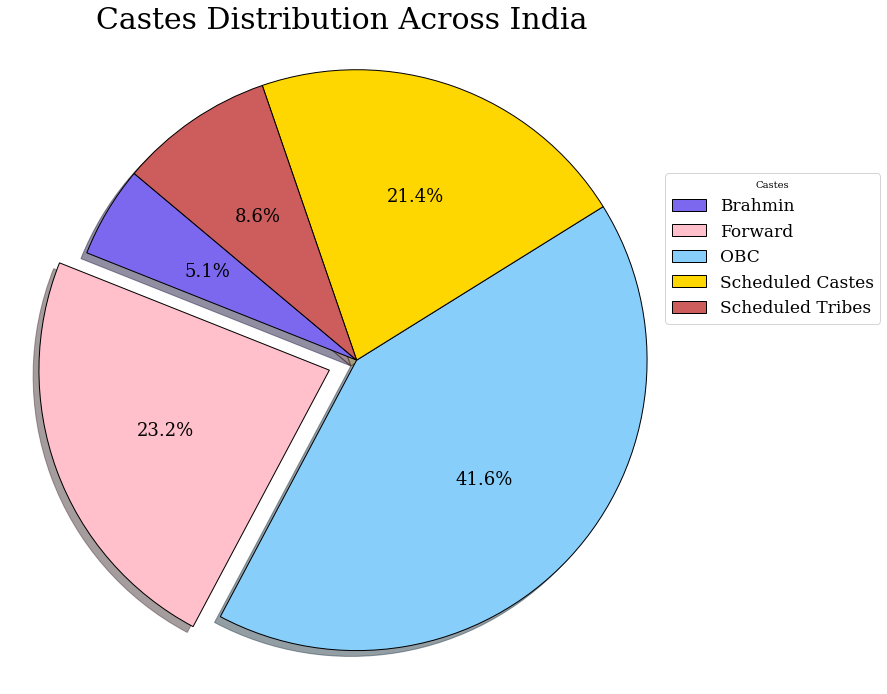

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Data to plot
fig = plt.figure(figsize = (12,12))

labels = g.index
sizes = g['State']
colors = ['mediumslateblue', 'pink', 'lightskyblue', 'gold', 'indianred']
explode = (0,0.1, 0, 0, 0)  # explode 1st slice

# Plot
patches, text, _ = plt.pie(sizes, colors=colors,
autopct='%1.1f%%', shadow=True, explode = explode, startangle=140, wedgeprops={"edgecolor":"k", 'antialiased': True}, textprops={'fontsize': 18})

plt.legend(patches, labels,bbox_to_anchor=[0.97, 0.8], prop={'size': 17}, title = 'Castes', fancybox=True)
plt.title('Castes Distribution Across India', fontsize=30)

plt.axis('equal')

plt.savefig('/content/drive/Shareddrives/Big Data Project/caste_dist_pie2.png')

plt.show()

Observing the pie chart we can notice that the two lower castes are considered a reloatively large minority, and comprise together 25% of total population. The largest caste group are the Other Backward Caste (OBC), which is still considered as a disadvanteged caste, but still higher than SC and ST.

We can see that the Brahmin and Forward caste, the "top castes", the only groups without affirmative action by law, comprise a small portion of the population (28.3%). This means that most of india's population are considered to be of weak social-economic status, and possibly affected by the caste system.

### Plotting a States' Map

After viewing castes' distribution, we would like to see how these castes disperse grographically. 

In [ ]:
# get cordinates of each district

@lru_cache(maxsize=256)
def get_location(loc):
    time.sleep(1)
    return geolocator.geocode(loc)

In [ ]:
#sample random point within a polygon in order to locate different castes within the same state in different locations
def sample_polygon(geometry):
  # find the bounds of your geodataframe
  x_min, y_min, x_max, y_max = map_df.total_bounds

  # set sample size
  n = 100
  # generate random data within the bounds
  x = np.random.uniform(x_min, x_max, n)
  y = np.random.uniform(y_min, y_max, n)

  # convert them to a points GeoSeries
  gdf_points = gpd.GeoSeries(gpd.points_from_xy(x, y))
  # only keep those points within polygons
  gdf_points = gdf_points[gdf_points.within(map_df['geometry'].unary_union)]
  return gdf_points

  #sample randomly one point within polygon
def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points 

points = random_points_in_polygon(1, map_df.iloc[0].geometry)

As mentioned before, gevernment census data includes only ST and SC castes. In order to include all castes in the map, we'll differentiate 

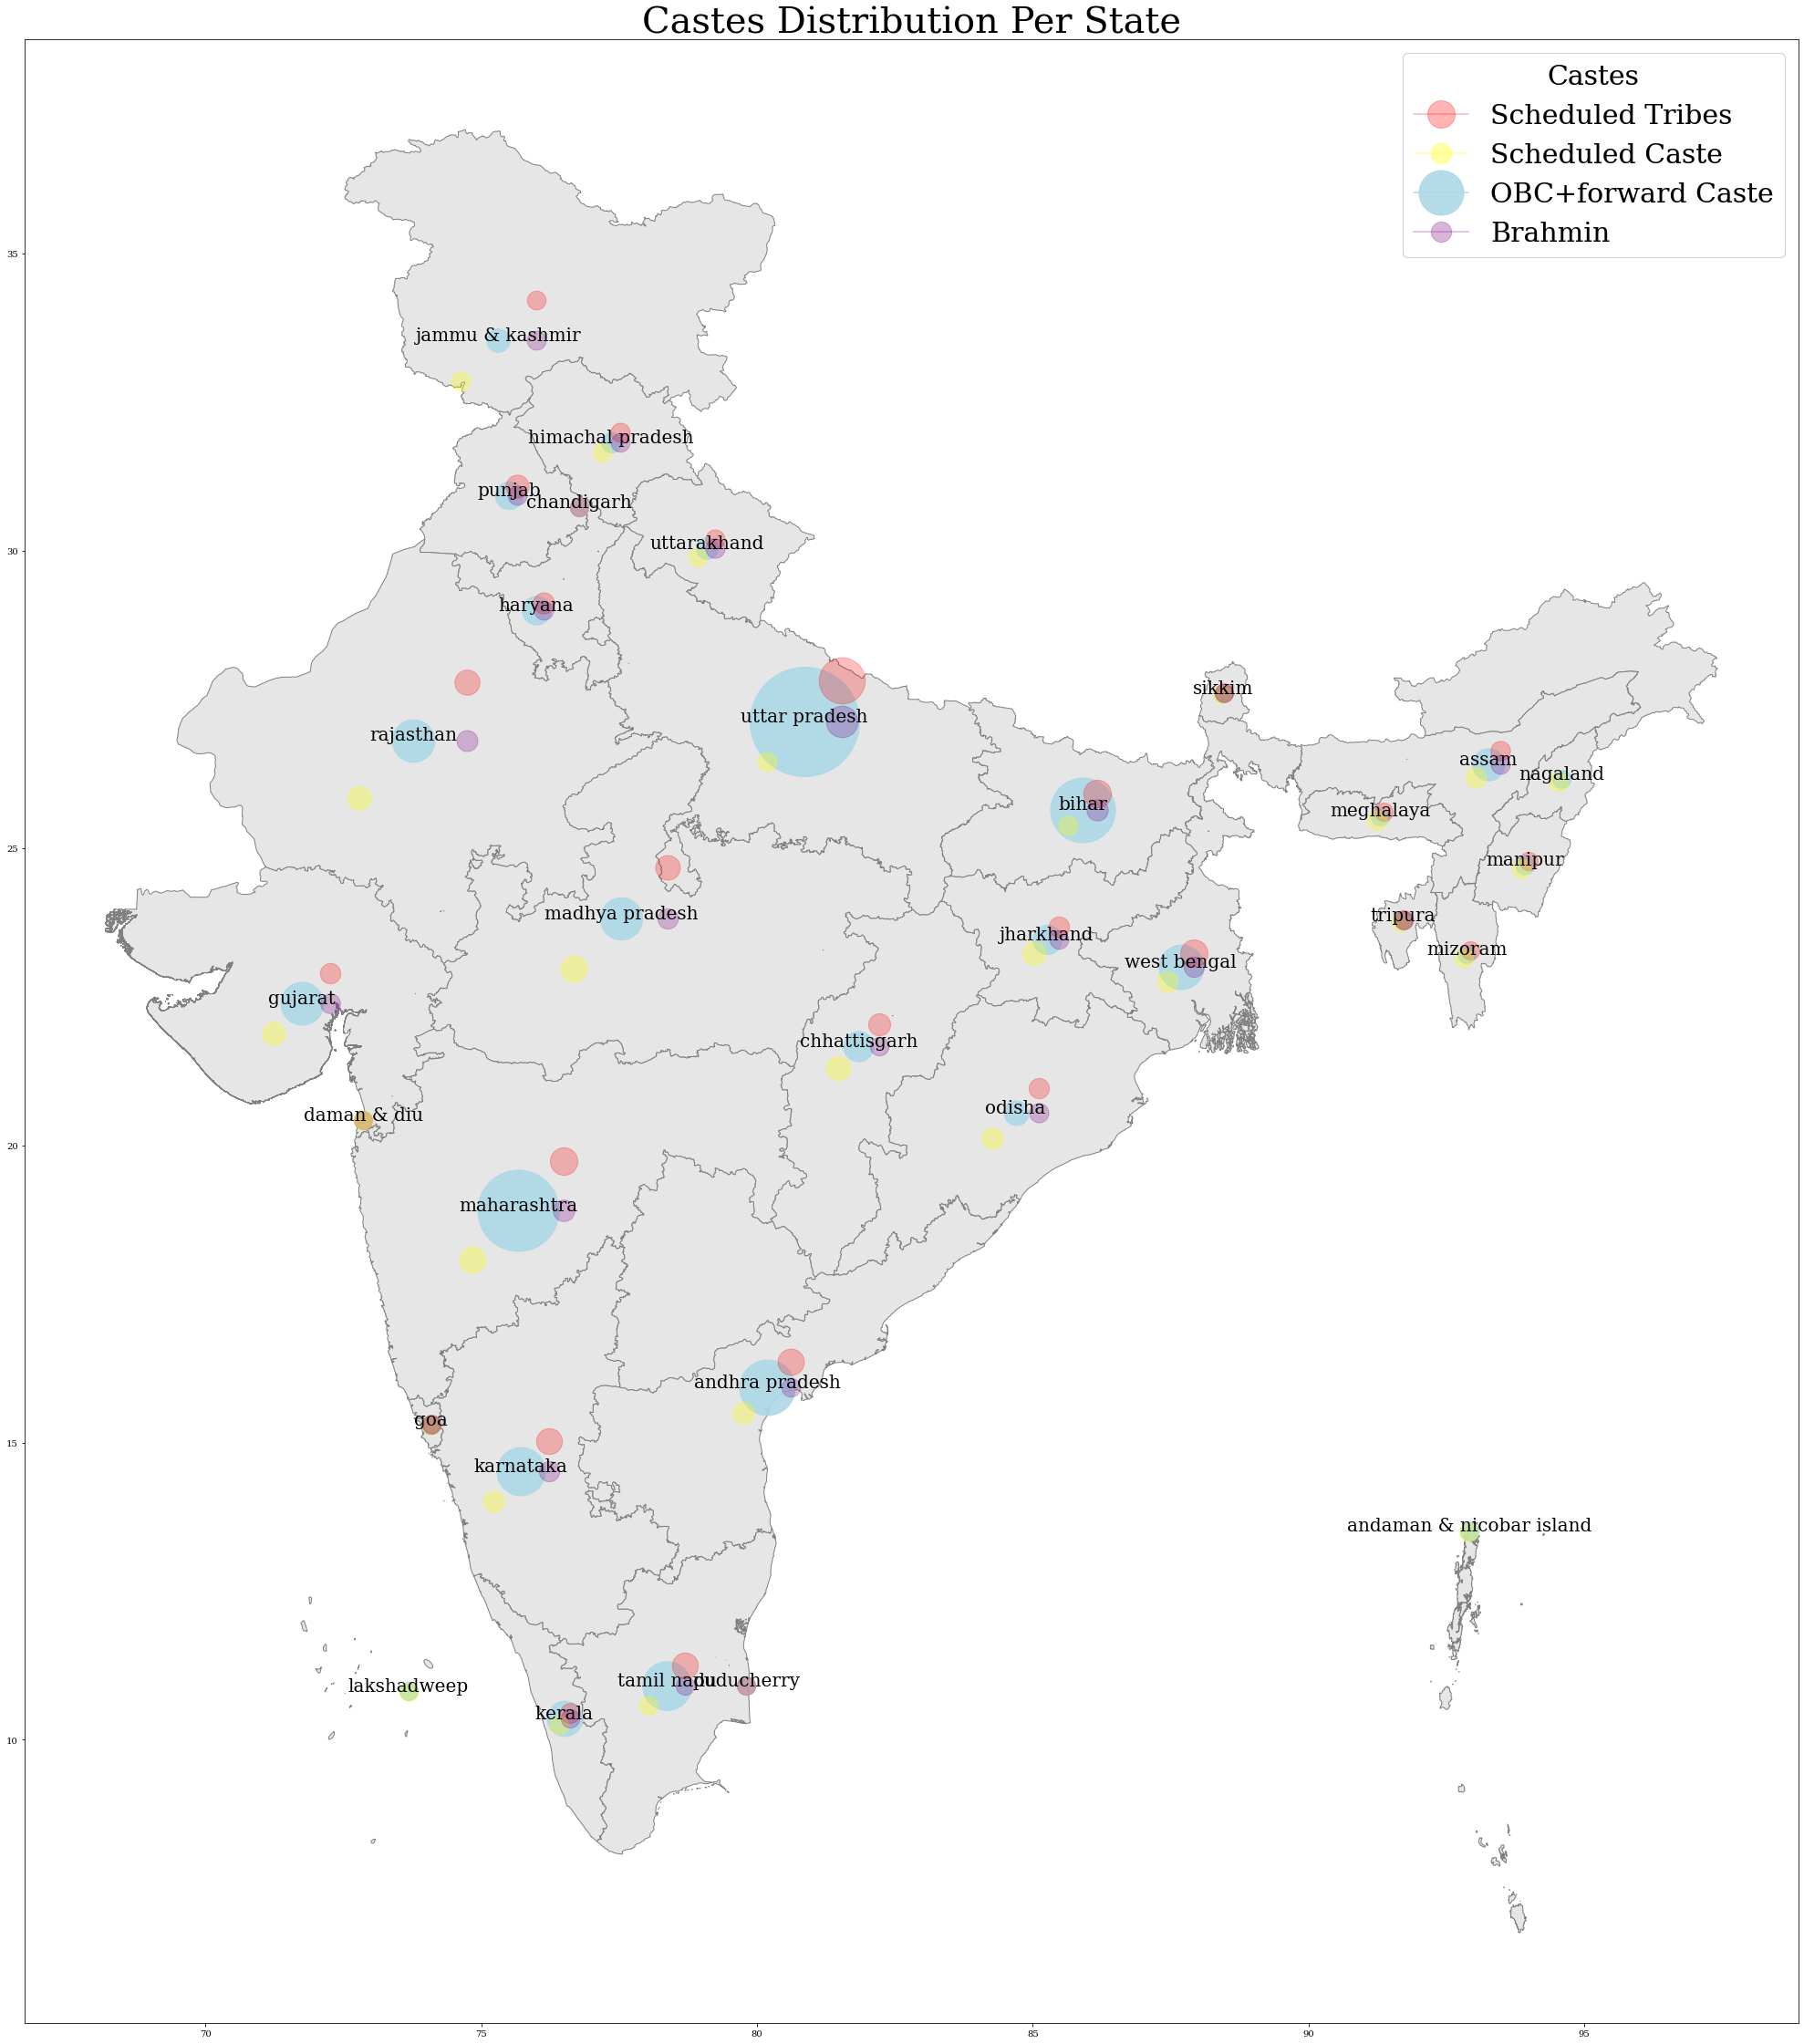

In [ ]:
fig, ax = plt.subplots(figsize=(40,40))
map_df.plot(ax=ax, color= '0.9', edgecolor='gray')
merged = merged[merged['state']!='baksa']
pop_df = pd.Series(merged.OTHER_P.values,index=merged.state).to_dict()

m = interp1d([4,max(pop_df.values())],[20,120])


for loc, v in pop_df.items():
    try:  
      location = get_location(loc)
      if location is None:
          continue
     
      ax1 = plt.plot(location.longitude ,location.latitude, marker='o', color='lightblue', markersize=m(v), alpha = 0.9)
      plt.annotate(s=loc, xy=(location.longitude,location.latitude),
                    horizontalalignment='center', fontsize=20,color="black")
    except Exception:
      pass
      
pop_df = pd.Series(merged.P_SC.values,index=merged.state).to_dict()

for loc, v in pop_df.items():
    try:  
      location = get_location(loc)
      if location is None:
          continue

      #calculate a factor by which we will divert locations for different castes within the same state to avoid overlapping points
      area_factor = map_df[map_df['st_nm'] == loc]['geometry'].area.values[0]/32
      ax2 = plt.plot(location.longitude + area_factor,location.latitude + area_factor, marker='o', color='red', markersize=m(v), alpha = 0.25)
      
    except Exception:
      pass

pop_df = pd.Series(merged.P_ST.values,index=merged.state).to_dict()

for loc, v in pop_df.items():
    try:  
      location = get_location(loc)
      if location is None:
          continue

      area_factor = map_df[map_df['st_nm'] == loc]['geometry'].area.values[0]/32
      ax3 = plt.plot(location.longitude - area_factor,location.latitude - area_factor, marker='o', color='yellow', markersize=m(v), alpha = 0.3)
      
    except Exception:
      pass

pop_df = pd.Series(merged.P_BR.values,index=merged.state).to_dict()

for loc, v in pop_df.items():
    try:  
      location = get_location(loc)
      if location is None:
          continue

      area_factor = map_df[map_df['st_nm'] == loc]['geometry'].area.values[0]/32
      ax4 = plt.plot(location.longitude + area_factor,location.latitude, marker='o', color='purple', markersize=m(v), alpha = 0.25)
      
    except Exception:
      pass


map_plots = [ax2,ax3,ax1,ax4]
legend = plt.legend([l[0] for l in map_plots],["Scheduled Tribes", "Scheduled Caste","OBC+forward Caste", "Brahmin"], loc = 'upper right', prop={'size': 30}, title = 'Castes', fancybox=True)
plt.setp(legend.get_title(),fontsize=30)
plt.gca().add_artist(legend)

# fig_legend.legend(['red', ''], ['Other', 'Scheduled Tribes', 'Scheduled Caste']), loc='center', frameon=False)

plt.title('Castes Distribution Per State', fontsize = 40)
plt.savefig('/content/drive/Shareddrives/Big Data Project/caste_map3.png')
plt.show()

The map and pie chart above shows that the majority of residents do not belong to the lower SC and ST castes. It seems that for rural and remote areas there is a majority of SC and STs.


## Caste Related Gaps in the Legal System

Let's observe whether a person's caste could be related to it's legal status.
We obtained data describing different poroperties of convicted fellons, including their caste. We wanted to investigate whether india's prisons contain a higher percentage of lower castes.

We should state that a higher percentage of SCs and STs in prisons does not neccassarily mean they are discriminated by the legal system. It could also mean that they have a lower starting point which lead them to crime

In [ ]:
!kaggle datasets download -d rajanand/prison-in-india
!unzip /content/prison-in-india.zip
prison_df = pd.read_csv('/content/Caste.csv')
prison_df.head()

In [ ]:
#group data per year and caste in order to view change in convictions throughout time
prison_per_year = prison_df.groupby(['year', 'caste'], as_index = False).sum()
prison_per_year.head()

,year,caste,is_state,convicts,under_trial,detenues,others
0,2001,OBC,54,21389,61209,867,6949
1,2001,Others,54,23453,66974,981,1550
2,2001,SC,54,17152,54878,845,4423
3,2001,ST,54,11108,27733,351,720
4,2002,OBC,54,22922,56614,1157,4718


Since the amount of convicts per caste is directly effected by the size of the caste in the overall population, we decided to factorize the number of prisoners by their percentage of population 

*as presented in the distribution data above)*

In [ ]:
#add factor according to caste's size in population

caste_dict = {'ST':0.09, 'SC':0.21, 'OBC':0.42, 'Others':0.28}

def factor_caste(caste, convicts):
  return convicts/caste_dict[caste]

prison_per_year['Factorized Convicts'] = prison_per_year.apply(lambda x: factor_caste(x['caste'], x['convicts']), axis = 1)
prison_per_year.head()

,year,caste,is_state,convicts,under_trial,detenues,others,Factorized Convicts
0,2001,OBC,54,21389,61209,867,6949,50926.190476
1,2001,Others,54,23453,66974,981,1550,83760.714286
2,2001,SC,54,17152,54878,845,4423,81676.190476
3,2001,ST,54,11108,27733,351,720,123422.222222
4,2002,OBC,54,22922,56614,1157,4718,54576.190476


In [ ]:
prison_per_year['% convictions'] = prison_per_year.apply(lambda x: x['convicts']/x['under_trial'], axis = 1)
fig = px.scatter(prison_per_year, x="year", y="% convictions", color="caste", hover_name="caste", size = "Factorized Convicts" )

fig.update_layout(
    title={
        'text': "Convictions per Caste Over Time",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
        family="Times New Roman",
        size=30)
})
fig.update_xaxes(title_font=dict(size=18, family='Times New Roman'))
fig.update_yaxes(title_font=dict(size=18, family='Times New Roman'))

fig.show()

We see either an increase in convicts and convictions in 2004 (or an increase in data). Moreover, the percentage of convictions for the lowe caste ST remains significantly high throught 2001-2011, and seems to decrease in 2012, where all castes seemed to be much more aligned.

In [ ]:
df = prison_per_year

fig = px.bar(df.sort_values(by = ['year', 'caste']), x="caste", y="Factorized Convicts", color = 'convicts', color_continuous_scale='matter',
  animation_frame="year", animation_group="caste", hover_data = ['caste', 'year', 'convicts', 'under_trial'], range_y = [0,250000])

for data in fig.data:
    data["width"] = 0.5

fig.update(layout_coloraxis_showscale=False)
fig.update_layout(
    title={
        'text': 'Number of Convicts per Caste Over Time',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
        family="Times New Roman",
        size=30)
})
fig.update_xaxes(title_font=dict(size=18, family='Times New Roman'))
fig.update_yaxes(title_font=dict(size=18, family='Times New Roman'))

fig.show()

The above plot indicates two possible insights:
1. Over time, the low ST caste represents a higher percentage of prisoners than other castes
2. It appears like the factorized amount of convicts has increased over the years, possibly due to more data



## Covid-19 Cases Throught India

we found multiple sources [5,6] which claimed that lower castes are more susceptive to the corona virus since:
1. SCs usualy have low-hygiene positions, which will lead to more frequent exposure
2. lower caste residents do not have access to good health care


We obtained a data set depicting the number of patients, cured and deaths throughout the pandemic (01/2020-12/2020). While the data is not caste oriented, we wanted to see if we could link between affected regions and their caste distribtution

###Data Loading and Preprocessing

In [ ]:
!kaggle datasets download -d sudalairajkumar/covid19-in-india
!unzip -d datasets /content/covid19-in-india.zip
cov_df = pd.read_csv('/content/datasets/covid_19_india.csv')

In [ ]:
cov_df.rename(columns={"State/UnionTerritory": "state"}, inplace = True)

we wanted to examine the percentage of lower castes (SC and ST) from the states' population, and see whether it is connected to the amount of covid cases or deaths

In [ ]:
#use the districts dataframe (from the map section) to represent percentage of lower castes in each state
pop_df = merged[merged['TOT_P']>0]
pop_df['lower_caste'] = pop_df.apply(lambda x: (x['P_SC']+x['P_ST'])/x['TOT_P'], axis = 1)
pop_df.head()

,gid,TOT_P,P_SC,P_ST,state,P_BR,OTHER_P,lower_caste
0,1,380581.0,0.0,28530.0,andaman & nicobar island,0.00,3.520510e+05,0.074964
1,864,169161554.0,27756156.0,11836146.0,andhra pradesh,1691615.54,1.278776e+08,0.234050
3,84,62411152.0,4462642.0,7768742.0,assam,2496446.08,4.768332e+07,0.195981
4,148,204533518.0,32299612.0,2670828.0,bihar,10226675.90,1.593364e+08,0.170977
5,10,2110900.0,398172.0,0.0,chandigarh,0.00,1.712728e+06,0.188627


In [ ]:
cov_df['state'] = cov_df['state'].str.lower()
cov_df['state'] = cov_df.apply(lambda x: x['state'].replace('***', ''), axis = 1 )
cov_df['state'] = cov_df.apply(lambda x: x['state'].replace(' and ', ' & '), axis = 1 )


covid_df = cov_df.groupby('state', as_index = False).sum()
covid_df = covid_df.join(pop_df.set_index('state')[['lower_caste', 'TOT_P']], on = 'state')
covid_df['cases_per_population'] = covid_df.apply(lambda x: (x['Confirmed']/x['TOT_P']*100), axis = 1)
covid_df = covid_df[covid_df['cases_per_population']<100]
covid_df.dropna(axis = 0, inplace=True)
covid_df.head()

,state,Sno,Cured,Deaths,Confirmed,lower_caste,TOT_P,cases_per_population
1,andhra pradesh,1230851,76025563,715536,84815303,0.234050,169161554.0,50.138640
3,assam,1225766,18920926,85655,21703581,0.195981,62411152.0,34.775165
4,bihar,1229860,21690764,121993,23891385,0.170977,204533518.0,11.680914
6,chandigarh,1230917,1196101,20701,1403514,0.188627,2110900.0,66.488891
7,chhattisgarh,1231073,13106333,170085,16051609,0.439365,75961671.0,21.131195


### Plot Covid Cases per State and Caste Distribution

In [ ]:
fig = px.scatter(covid_df, x="state", y="cases_per_population",
	         size="TOT_P", color="lower_caste",
                 hover_name="state", size_max=60,  color_continuous_scale = 'sunset')

fig.update_layout(
    title={
        'text': "Distribution of Covid Cases per States",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
        family="Times New Roman",
        size=30)
})
fig.update_xaxes(title_font=dict(size=18, family='Times New Roman'))
fig.update_yaxes(title_font=dict(size=18, family='Times New Roman'))                 
fig.show()

most states presented a relatively low percentage of lower castes, making it harder to view this data from a caste point of view

We were able to see that states with a majority of SC and STs contain fewer residents and also a low number of cases per population. These are rural states where it is possible that corona had not reached. Moreover, larger cities include more traffic and even higher castes are more likely to travel, thus dispersing the virus.

In addition, it is possible that these rural areas have less data.

## Twitter Caste Analysis Data

Social media has become a highly common tool to express opinions and connect with others. In order to evaluate the social status of different caste members, we wanted to see how they interact on social media.

We decided to explore Twitter, one of the larget social networks today. As described in [7], caste discrimination was documented to take place in twitter, and could present relationships between caste groups.
Using a twitter's developer account, we obtained tweets which originated from india and included a caste related search word for the period between 01/02/2021 - 09/02-2021, and evaluated both their content and the character of the connection between the tweets' posters.



### Twitter Data Extraction and Preprocessing

In [ ]:
consumer_key = "v9GvRipNqyPEI6a1Rbf3Tlbmq"
consumer_secret = "TKlvnDkksJGaSKALANCtLClrUOxmPkqjGpqYM3CWjVaCr6PEja"
access_token = "1355445124118016002-ZgQJcRZqVXOXm27s7cvI729vEmGW2K"
access_token_secret = "RGkFCiDzSCnMsBVXaYBbQiaxHycpfxx0OQ2KA6zwtBoVd"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
# function to perform data extraction 
def scrape(words, date_since, numtweet): 
	
	# Creating DataFrame using pandas 
  df = pd.DataFrame(columns=['username', 'description', 'location', 'following', 
							'followers', 'totaltweets', 'retweetcount', 'text', 'hashtags', 'usermentions']) 
	
	# We are using .Cursor() to search through twitter for the required tweets. 
	# The number of tweets can be restricted using .items(number of tweets) 
  tweets = tweepy.Cursor(api.search, q=words, lang="en", 
						since=date_since, tweet_mode='extended').items(numtweet) 

  list_tweets = [tweet for tweet in tweets] 
	
	# Counter to maintain Tweet Count 
  i = 1
	
	# we will iterate over each tweet in the list for extracting information about each tweet 
  for tweet in list_tweets:
    username = tweet.user.screen_name
    description = tweet.user.description
    location = tweet.user.location
    following = tweet.user.friends_count
    followers = tweet.user.followers_count
    totaltweets = tweet.user.statuses_count
    retweetcount = tweet.retweet_count
    hashtags = tweet.entities['hashtags']
    usermentions = tweet.entities['user_mentions']
		

    try: 
      text = tweet.retweeted_status.full_text 
    except AttributeError: 
      text = tweet.full_text 
    hashtext = list() 
    for j in range(0, len(hashtags)): 
      hashtext.append(hashtags[j]['text']) 
		
		# Here we are appending all the extracted information in the DataFrame 
    ith_tweet = [username, description, location, following, 
          followers, totaltweets, retweetcount, text, hashtext,usermentions] 
    df.loc[len(df)] = ith_tweet 
		
    i = i+1

  return df

queries = {'Brahmin':'Bhramin OR Brahmin OR brahmin OR bhramin OR #Brahmin OR #Bhramin', 'OBC': 'obc OR OBC or #OBC OR #obc OR other backward class',\
           'Scheduled Caste': ' SC OR sc OR #SC OR #sc OR Scheduled caste OR #Scheduled caste OR scheduled caste', 'Scheduled Tribes': ' ST OR st OR #ST OR #st OR Scheduled tribes OR #Scheduled tribes OR scheduled tribes'}
date_since = '2021-02-01'
#limit of tweets since a higher number crashed our query (2000 for each caste search words)
num_tweets = 2000

temp = scrape('obc OR OBC OR #OBC OR #obc OR other backward class', date_since, num_tweets)
temp['topic'] = 'OBC'
twitter_df = twitter_df.append(temp, ignore_index = True)

In [ ]:
twitter_df.head()

,username,description,location,following,followers,totaltweets,retweetcount,text,hashtags,usermentions,topic
0,AhmedPk65943257,A Muslim Pakistani Who wants to Ins Shaa Allah...,Pakistan,3850,1299,36562,196,Caste system in Brahmin ruled India is the gre...,[],"[{'screen_name': 'ZaidZamanHamid', 'name': 'Za...",Brahmin
1,sarpame,"Proud ಕನ್ನಡಿಗ ,\nPresident @ Samanya Kannadiga...",,181,605,2004,0,@ashi_mahe @Sangamchand3 @crp9786 Nope ! .. we...,[],"[{'screen_name': 'ashi_mahe', 'name': 'Ashish ...",Brahmin
2,Secular_Kaptaan,Jagat Guru Bhakt,,92,21,660,0,@yoginisd A civil disagreement followed by a d...,[],"[{'screen_name': 'yoginisd', 'name': 'Yogini',...",Brahmin
3,Johnny57061333,Johnny is happy,,1450,218,7217,1,@RahulGandhi Why Congress is not revailing Bra...,[],"[{'screen_name': 'BinoyBas', 'name': 'Shyam', ...",Brahmin
4,sivakumar_kavi,Born to win 👍,"Chennai, India",417,53,1372,0,@Ramyahariharan4 You Brahmin tamilian so u wil...,[],"[{'screen_name': 'Ramyahariharan4', 'name': 'R...",Brahmin


In [ ]:
twitter_df.to_csv('/content/drive/Shareddrives/Big Data Project/twitter_data.csv', index = False)

### Connect Between the Person who Posted the Tweet and Tagged Users for Netowrk Creation

each node represents a twitter user, and each edge a connection between them (the poster tagged another user within the post). the context of each user interaction is selected by key words and hashtags per tweet

In [ ]:
connections = pd.DataFrame(columns=['username', 'retweetcount', 'text', 'topic', 'user_mention'])

def get_users(user_list):
  names = []
  for user_dict in user_list:
    names.append(user_dict['screen_name'])
  return names


r_counter = 0
for i,row in twitter_df.iterrows():
  if len(row['usermentions']) > 0:
    names = get_users(row['usermentions'])

    for name in names:
      connections.loc[r_counter] = pd.Series({'username':row['username'], 'retweetcount':row['retweetcount'], 'text':row['text'], 'topic':row['topic'], 'user_mention':name})
      r_counter += 1

connections.shape[0]

5920

In [ ]:
connections.head()

,username,retweetcount,text,topic,user_mention
0,AhmedPk65943257,196,Caste system in Brahmin ruled India is the gre...,Brahmin,ZaidZamanHamid
1,sarpame,0,@ashi_mahe @Sangamchand3 @crp9786 Nope ! .. we...,Brahmin,ashi_mahe
2,sarpame,0,@ashi_mahe @Sangamchand3 @crp9786 Nope ! .. we...,Brahmin,Sangamchand3
3,sarpame,0,@ashi_mahe @Sangamchand3 @crp9786 Nope ! .. we...,Brahmin,crp9786
4,Secular_Kaptaan,0,@yoginisd A civil disagreement followed by a d...,Brahmin,yoginisd


In [ ]:
#count users topics to determine v2 user topic
topics = pd.get_dummies(connections['topic'])
user_topics = pd.concat([connections,topics], axis = 1)
user_topics = user_topics[['username', 'Brahmin', 'OBC', 'Scheduled Caste', 'Scheduled Tribes']]

sum_df = user_topics.groupby('username', as_index = False).sum()
sum_df.head()

,username,Brahmin,OBC,Scheduled Caste,Scheduled Tribes
0,007kiran_,1,0,0,0
1,01_djbhatt,0,0,1,0
2,0209Abhishek,0,0,0,1
3,0807ankit,0,0,2,0
4,0912abhi,0,0,1,0


In [ ]:
user_list = list(connections['username'].unique())
connections = connections[connections['user_mention'].isin(user_list)]

In [ ]:
connections.head()

,username,retweetcount,text,topic,user_mention
1,sarpame,0,@ashi_mahe @Sangamchand3 @crp9786 Nope ! .. we...,Brahmin,ashi_mahe
5,Johnny57061333,1,@RahulGandhi Why Congress is not revailing Bra...,Brahmin,BinoyBas
19,amritpu0,2,Brahmin- Savarna's diversity be like\n\n- Delh...,Brahmin,balwindEr_24
20,beera_2002,24,@TSeries can you tell me why do you have a son...,Brahmin,Hayatokaw
22,bowingtomyQueen,20,"@yoginisd Had you used this ""tail tucked in la...",Brahmin,Hayatokaw


In [ ]:
def get_topic(user):
  try:
    curr = sum_df[sum_df['username'] == user]
    curr = curr.drop('username', axis = 1)
    return curr.idxmax(axis=1).values[0]
  except IndexError:
    print(user)

connections['v2_topic'] = connections.apply(lambda x: get_topic(x['user_mention']), axis = 1)
connections.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,username,retweetcount,text,topic,user_mention,v2_topic
1,sarpame,0,@ashi_mahe @Sangamchand3 @crp9786 Nope ! .. we...,Brahmin,ashi_mahe,Brahmin
5,Johnny57061333,1,@RahulGandhi Why Congress is not revailing Bra...,Brahmin,BinoyBas,Brahmin
19,amritpu0,2,Brahmin- Savarna's diversity be like\n\n- Delh...,Brahmin,balwindEr_24,Brahmin
20,beera_2002,24,@TSeries can you tell me why do you have a son...,Brahmin,Hayatokaw,Brahmin
22,bowingtomyQueen,20,"@yoginisd Had you used this ""tail tucked in la...",Brahmin,Hayatokaw,Brahmin


In [ ]:
#create the graph
import turicreate
from turicreate import SFrame
import networkx as nx

sf = SFrame(data=connections)

ng = nx.Graph()

for row in sf:
    v1 = row['username']
    v2 = row['user_mention']
    ng.add_node(v1, topic = row['topic'], retweerCount = row['retweetcount'])
    ng.add_node(v2, topic = row['v2_topic'], retweerCount = 0)
    ng.add_edge(v1,v2)

nx.info(ng)

Name: Type: Graph 
Number of nodes: 2772 
Number of edges: 2997 
Average degree: 2.1623


In [ ]:
nx.write_gml(ng,"/content/drive/Shareddrives/Big Data Project/twitter_090221.gml")
connections.to_csv('/content/drive/Shareddrives/Big Data Project/twitter_connections_df.csv', index = False)

After creating the preliminary network, we decided to sample tweets that represnted connections between different castes. 
We noticed that most inner-caste conversations had a positive note, while cross-caste comments were more hostile or aggressive.

In [ ]:
connections[connections['topic'] != connections['v2_topic']]

,username,retweetcount,text,topic,user_mention,v2_topic
216,Ravichiruvolu1,6,@IndianRajeshNCo @JaganNKaushik @prasad_perla ...,Brahmin,sumelg2,Scheduled Caste
504,AjitsinhJagirda,2,@AjitsinhJagirda @surewrap @sharma_jyo @nair_h...,Brahmin,macharajarao,Scheduled Caste
631,nair_hena,2,@AjitsinhJagirda @surewrap @sharma_jyo @nair_h...,Brahmin,macharajarao,Scheduled Caste
645,NationmyFamily,2,@AjitsinhJagirda @surewrap @sharma_jyo @nair_h...,Brahmin,macharajarao,Scheduled Caste
718,NoGenuine,0,@sdesai41 @conscienceisimp @gopikaruppu @gowdl...,Brahmin,gopikaruppu,Scheduled Caste
...,...,...,...,...,...,...
5879,KTGupta3,535,Draft Communal Violence Bill 2011 - Definition...,Scheduled Tribes,Sanjay_Dixit,Brahmin
5880,maribaltbharti,535,Draft Communal Violence Bill 2011 - Definition...,Scheduled Tribes,Sanjay_Dixit,Brahmin
5881,StoryofDatum,535,Draft Communal Violence Bill 2011 - Definition...,Scheduled Tribes,Sanjay_Dixit,Brahmin
5882,etip2020,535,Draft Communal Violence Bill 2011 - Definition...,Scheduled Tribes,Sanjay_Dixit,Brahmin


Presented herein are examples for hostile conversations between different castes.


In [ ]:
connections.iloc[-150]['text']

"Draft Communal Violence Bill 2011 - Definition of victim of communal violence - 'a religious or linguistic minority, in any State...or Scheduled Castes and Tribes.'\n\nImagine, this would be a licence to the aggressive minority to unleash riots at will, and remain victims."

In [ ]:
connections[connections['username'] == 'Sanjay_Dixit'].iloc[0]['text']

'KP/Brahmin Hatred in some circles is so intense as if we are responsible for all their miseries in their miserable lives. \n\nDid KPs propound Aryan theory? @Mewinnn every community has black sheeps why target KP/Brahmins only? https://t.co/R98sL6dXYH'

### Sentiment Analysis

Due to the observations described above, we decided to add sentiment analysis on the edges of our network, meaning we evaluated the sentiment of the original tweet, which included the other caste user tag

In [ ]:
#add sentiment analysis

def get_sentiment(text):
  blob = TextBlob(text)
  return blob.sentiment.polarity

connections['sentiment'] = connections.apply(lambda x: get_sentiment(x['text']), axis = 1)
connections.head()

,username,retweetcount,text,topic,user_mention,v2_topic,sentiment
1,sarpame,0,@ashi_mahe @Sangamchand3 @crp9786 Nope ! .. we...,Brahmin,ashi_mahe,Brahmin,0.10
5,Johnny57061333,1,@RahulGandhi Why Congress is not revailing Bra...,Brahmin,BinoyBas,Brahmin,0.00
19,amritpu0,2,Brahmin- Savarna's diversity be like\n\n- Delh...,Brahmin,balwindEr_24,Brahmin,0.75
20,beera_2002,24,@TSeries can you tell me why do you have a son...,Brahmin,Hayatokaw,Brahmin,0.00
22,bowingtomyQueen,20,"@yoginisd Had you used this ""tail tucked in la...",Brahmin,Hayatokaw,Brahmin,0.50


In [ ]:
#create the graph
sf = SFrame(data=connections)

ngs = nx.Graph()

for row in sf:
    v1 = row['username']
    v2 = row['user_mention']
    ngs.add_node(v1, topic = row['topic'], retweerCount = row['retweetcount'])
    ngs.add_node(v2, topic = row['v2_topic'], retweerCount = 0)
    ngs.add_edge(v1,v2, sentiment = row['sentiment'])

nx.info(ngs)

'Name: \nType: Graph\nNumber of nodes: 798\nNumber of edges: 849\nAverage degree:   2.1278'

In [ ]:
nx.write_gml(ngs,"/content/drive/Shareddrives/Big Data Project/twitters/twitter_sentiment_090221.gml")

In [ ]:
afinn = Afinn()

connections['afinn_score'] = connections['text'].apply(lambda t: afinn.score(t))
connections.head()

,username,retweetcount,text,topic,user_mention,v2_topic,sentiment,afinn_score
1,sarpame,0,@ashi_mahe @Sangamchand3 @crp9786 Nope ! .. we...,Brahmin,ashi_mahe,Brahmin,0.10,1.0
5,Johnny57061333,1,@RahulGandhi Why Congress is not revailing Bra...,Brahmin,BinoyBas,Brahmin,0.00,2.0
19,amritpu0,2,Brahmin- Savarna's diversity be like\n\n- Delh...,Brahmin,balwindEr_24,Brahmin,0.75,8.0
20,beera_2002,24,@TSeries can you tell me why do you have a son...,Brahmin,Hayatokaw,Brahmin,0.00,1.0
22,bowingtomyQueen,20,"@yoginisd Had you used this ""tail tucked in la...",Brahmin,Hayatokaw,Brahmin,0.50,-1.0


In [ ]:
#create the graph
sf = SFrame(data=connections)

ngs = nx.Graph()

for row in sf:
    v1 = row['username']
    v2 = row['user_mention']
    ngs.add_node(v1, topic = row['topic'], retweerCount = row['retweetcount'])
    ngs.add_node(v2, topic = row['v2_topic'], retweerCount = 0)
    ngs.add_edge(v1,v2, sentiment = row['afinn_score'])

nx.info(ngs)

'Name: \nType: Graph\nNumber of nodes: 798\nNumber of edges: 849\nAverage degree:   2.1278'

In [ ]:
nx.write_gml(ngs,"/content/drive/Shareddrives/Big Data Project/twitters/twitter_affin_090221.gml")

### Load Cytoscape Network

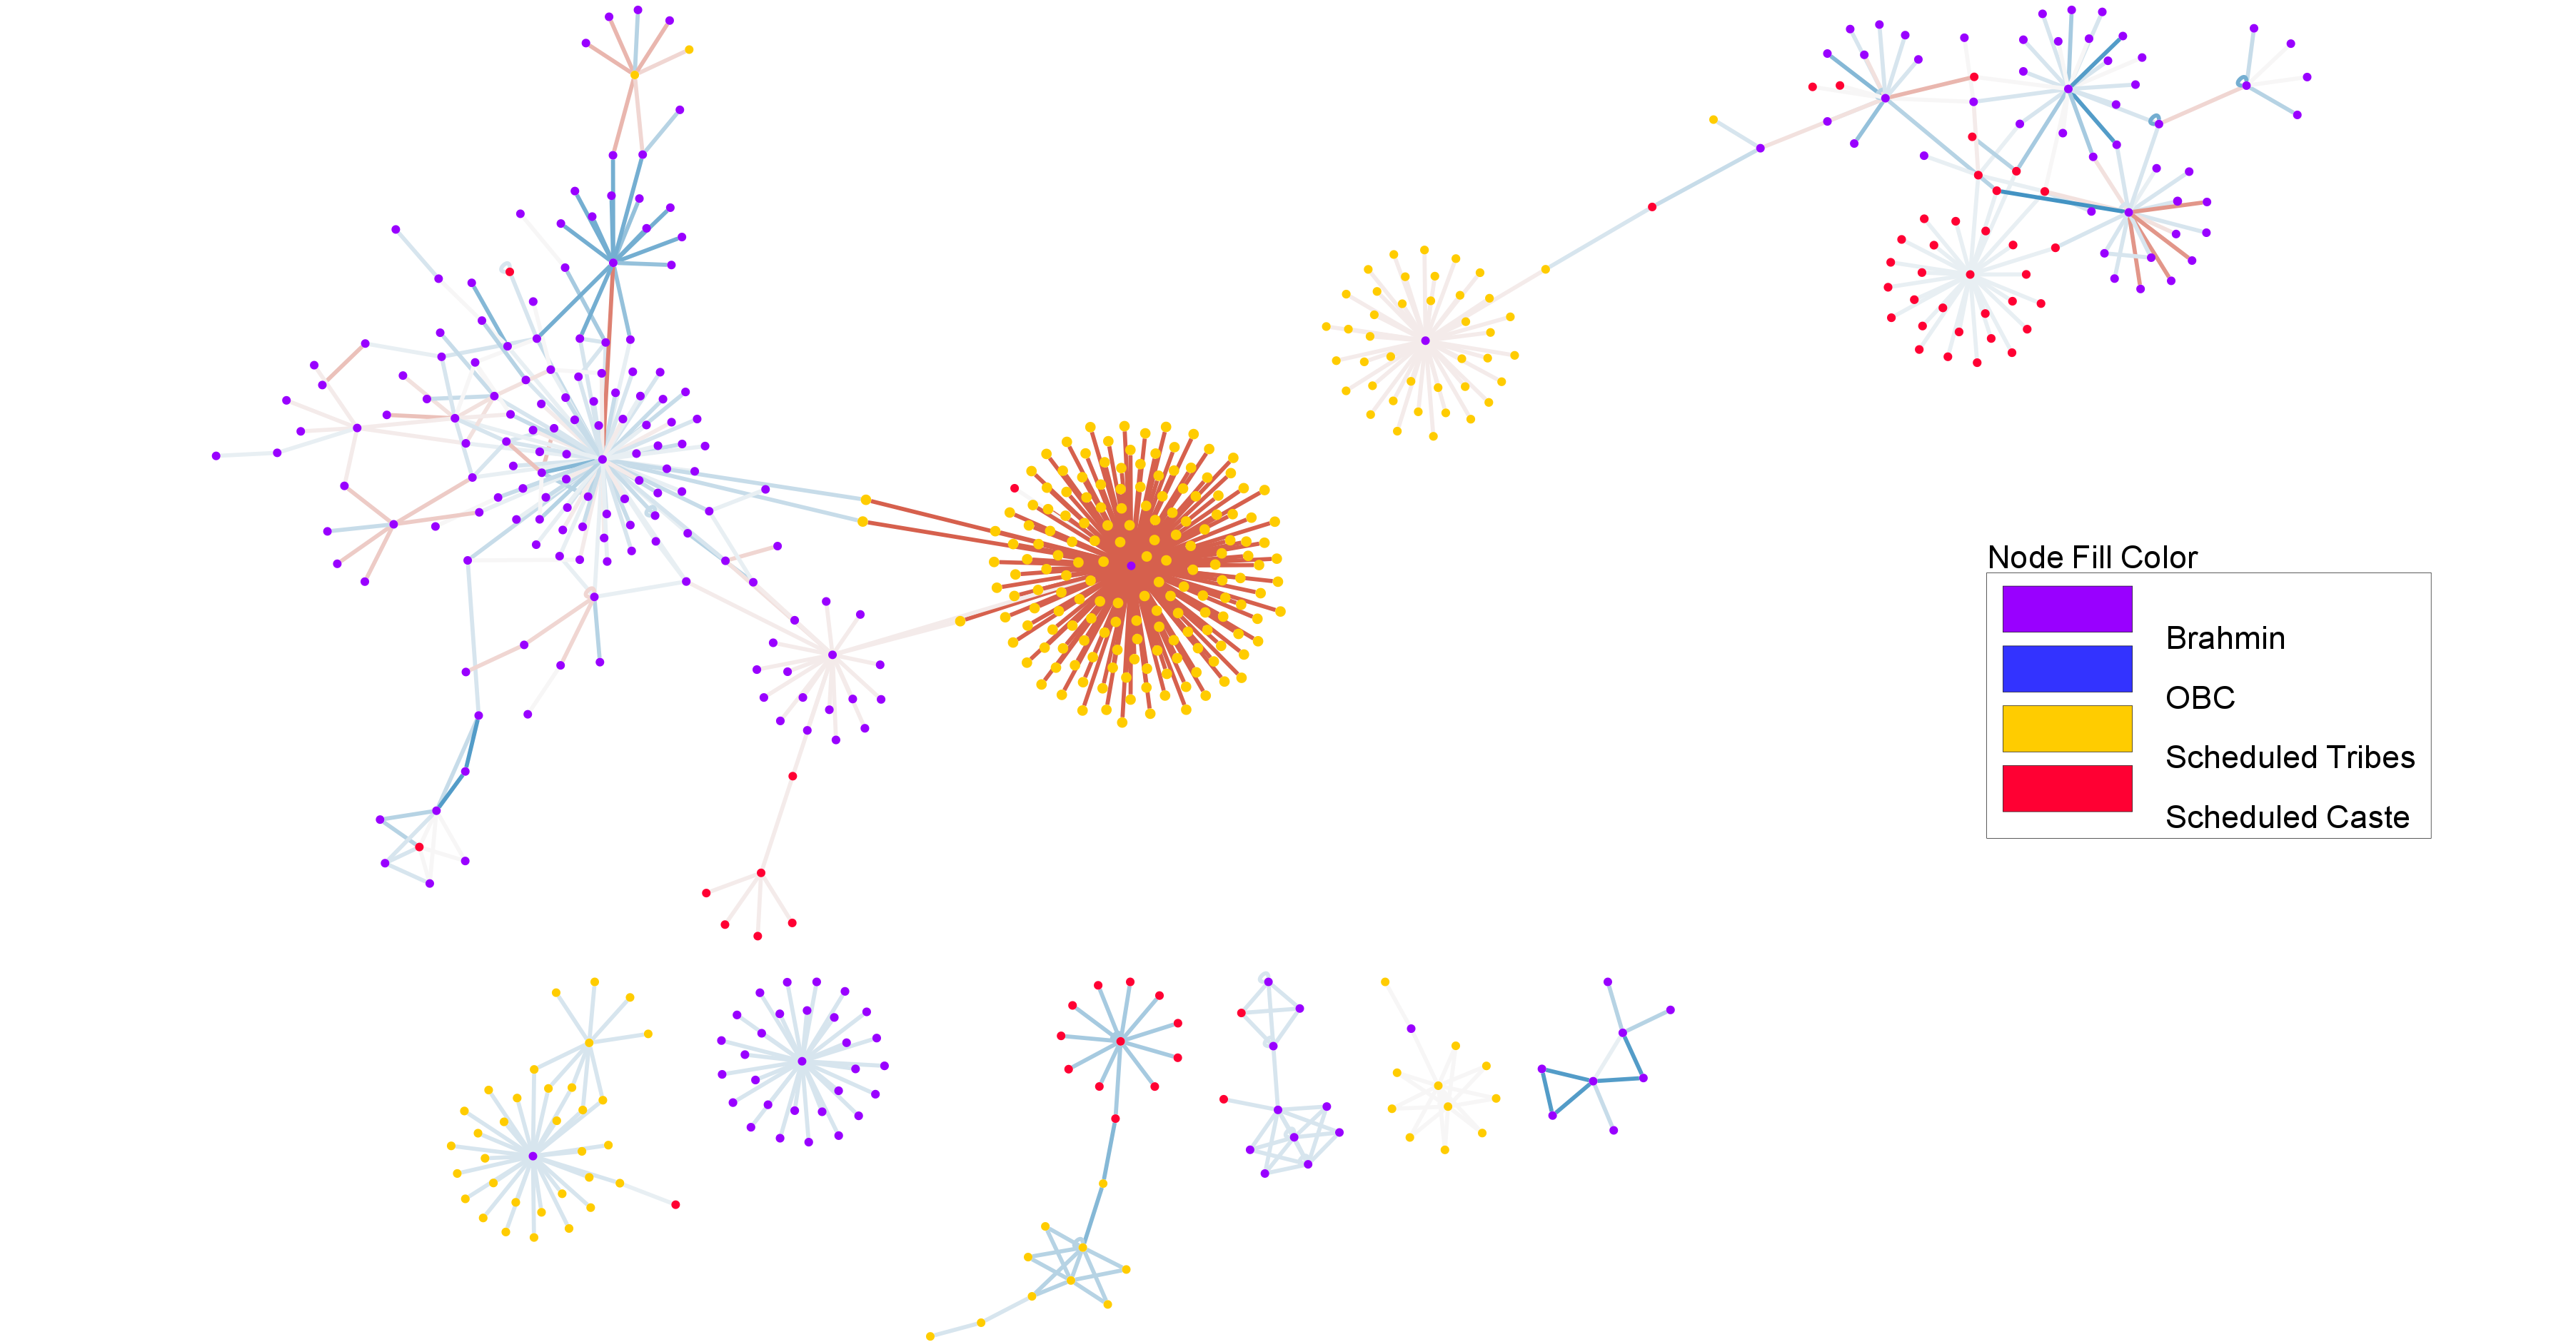

In [ ]:
Image('/content/drive/Shareddrives/Big Data Project/twitters/twitters_graph.png')

We can see that most clusters include the same caste, meaning usualy castes commincate within themselves.

However, for cases crossing between castes, our sentiment analysis shows a trend of negative (red edges) between different caste members (always brhamin to lower castes), and positive (blue edges) between the same caste members.

It's important to note that the negative interactions addresses a correspondence between a brahmin tweeter and sc/st tweeters. A good example for this is the red cluster containing one brahmin tweeter and many angry ST reponces. Even when inner caste conversations are not entirely positive (blue), they did not reach this level of negativity.

## **Education**




We obtained survey data from 2012, which included the relationship between caste and level of education. We should note that all data was labeled with codes and required some handeling 

### Data Loading and Preprocessing

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Big Data Project/ds_data/36151-0001-Data.tsv', delimiter='\t')
df.head()

,SURVEY,STATEID,DISTID,PSUID,HHID,HHSPLITID,PERSONID,IDPSU,IDHH,IDPERSON,WT,FWT,DIST01,DISTRICT,RO3,RO4,RO5,RO6,RO7,RO8,RO9,RO10,FM1,FM36Y,FM37,FM38,FMHOURS,WKFARM,FM39AY,AN1,AN5Y,AN6,AN7Y,NF1,NFBN1,NF9,NF12,NF13,NF15Y,NFBN21,...,NCHILDF,NTEENM,NTEENF,NELDERM,NELDERF,NMARRIEDM,NMARRIEDF,NWKNONAG,NWKAGLAB,NWKSALARY,NWKBUSINESS,NWKFARM,NWKANIMAL,NWKNREGA,NWKNREGA4,NWKNONNREGA,NWKANY5,INCNONAG,INCAGLAB,INCSALARY,INCNREGA,INCNONNREGA,NNR,HHEDUC,HHEDUCM,HHEDUCF,MG4,MG5,MG6,MG7,MG8,MG9NM,MG10,MG11,MGYEAR5,NMIG5,MGMONTHS5,MGYEAR1,NMIG1,MGMONTHS1
0,2,1,2,1,10,1,1,10201,102010101,10201010101,3687.93,3688,2,102,1,1,57,1,15,2,69,69,1,0,,,,0,0,1,0,0,0,0,0,,,,,0,...,2,1,0,0,0,2,2,2,0,3,0,0,1,0,0,2,3,30000,0,137200,0,30000,0,9,9,8,,,,,,,,,0,,,0,,
1,2,1,2,1,10,1,2,10201,102010101,10201010102,3687.93,3688,2,102,2,2,49,1,11,1,,,1,1,6,4,24,2,1,1,1,2,1,0,0,,,,,0,...,2,1,0,0,0,2,2,2,0,3,0,0,1,0,0,2,3,30000,0,137200,0,30000,0,9,9,8,,,,,,,,,0,,,0,,
2,2,1,2,1,10,1,3,10201,102010101,10201010103,3687.93,3688,2,102,1,3,19,2,13,,1,2,1,1,7,7,49,2,0,1,1,1,0,0,0,,,,,0,...,2,1,0,0,0,2,2,2,0,3,0,0,1,0,0,2,3,30000,0,137200,0,30000,0,9,9,8,,,,,,,,,0,,,0,,
3,2,1,2,1,10,1,4,10201,102010101,10201010104,3687.93,3688,2,102,2,3,14,2,12,,1,2,1,0,,,,0,0,1,0,0,0,0,0,,,,,0,...,2,1,0,0,0,2,2,2,0,3,0,0,1,0,0,2,3,30000,0,137200,0,30000,0,9,9,8,,,,,,,,,0,,,0,,
4,2,1,2,1,10,1,5,10201,102010101,10201010105,3687.93,3688,2,102,1,3,29,1,15,6,1,2,1,0,,,,0,0,1,0,0,0,0,0,,,,,0,...,2,1,0,0,0,2,2,2,0,3,0,0,1,0,0,2,3,30000,0,137200,0,30000,0,9,9,8,,,,,,,,,0,,,0,,


In [ ]:
df = df[df['INCOME']!=' ']
data = df[['ID13','RO7', 'EDUC7', 'ED7', 'ED12', 'MM7Y', 'MM8', 'CH15', 'RO5']]
data

,ID13,RO7,EDUC7,ED7,ED12,MM7Y,MM8,CH15,RO5
0,3,15,0,,,0,,,57
1,3,11,0,,,0,,,49
2,3,13,8,1,,0,,,19
3,3,12,5,0,,0,,,14
4,3,15,8,0,,0,,,29
...,...,...,...,...,...,...,...,...,...
204564,3,13,15,0,2,1,1,,26
204565,3,8,10,0,,1,1,,48
204566,3,11,8,0,,0,,,35
204567,3,12,10,0,1,1,1,,17


In [ ]:
data.rename(columns={'ID13':'caste', 'RO7':'employment status', 'EDUC7':'completed education', 'ED7':'repeated education', 'ED12':'highest degree', 'MM7Y':'computer', 'MM8':'internet', 'CH15':'student rank', 'RO5':'Age'}, inplace = True)
data = data[data['caste'] != ' ']
data = data[data['Age'] != ' ']
data['Age'] = data['Age'].astype('int')

#filter out young children to avoid a biased amount of low educated people
data = data[data['Age'] >=18]
data.drop('Age', axis = 1, inplace = True)
data.head()

,caste,employment status,completed education,repeated education,highest degree,computer,internet,student rank
0,3,15,0,,,0,,
1,3,11,0,,,0,,
2,3,13,8,1,,0,,
4,3,15,8,0,,0,,
5,3,11,8,0,,0,,


In [ ]:
def parse_caste(code):
  caste_dict = {'1':'Brahmin', '2':'Forward', '3':'OBC', '4':'Scheduled Castes', '5':'Scheduled Tribes', '6':'Other'}
  return caste_dict[str(code)]

data['caste'] = data.apply(lambda x: parse_caste(x['caste']), axis =1)

In [ ]:
data = data[data['completed education'] != ' ']
def parse_completed_education(code):
    ed_dict = {'0':'no education', '3':'1-4 years', '5':'primary (elementary)', '8':'6-9 years', '10':'secondary (10)', '12':'highschool (11-12)', '15':'university graduate', '16':'post-grad'}
    return ed_dict[str(code)]

data['completed education'] = data.apply(lambda x: parse_completed_education(x['completed education']), axis = 1)
data.head()

,caste,employment status,completed education,repeated education,highest degree,computer,internet,student rank
0,OBC,15,no education,,,0,,
1,OBC,11,no education,,,0,,
2,OBC,13,6-9 years,1,,0,,
4,OBC,15,6-9 years,0,,0,,
5,OBC,11,6-9 years,0,,0,,


In [ ]:
education_ranks = pd.get_dummies(data['completed education'])
caste_data = pd.concat([data,education_ranks], axis = 1)
caste_data = caste_data.drop(['employment status', 'completed education', 'repeated education', 'highest degree', 'computer', 'internet', 'student rank'], axis = 1)

caste_data = caste_data.groupby('caste', as_index = False).sum()

caste_data['total'] = caste_data.sum(axis=1)
caste_data

,caste,1-4 years,6-9 years,highschool (11-12),no education,post-grad,primary (elementary),secondary (10),university graduate,total
0,Brahmin,296.0,1512.0,1143.0,1023.0,597.0,549.0,1178.0,994.0,7292.0
1,Forward,2202.0,7203.0,4501.0,7093.0,1445.0,2192.0,5170.0,2843.0,32649.0
2,OBC,4492.0,12745.0,5317.0,17522.0,1194.0,4461.0,6601.0,2563.0,54895.0
3,Other,157.0,489.0,189.0,481.0,60.0,145.0,219.0,88.0,1828.0
4,Scheduled Castes,2141.0,6107.0,2208.0,10840.0,416.0,2294.0,2747.0,872.0,27625.0
5,Scheduled Tribes,1003.0,2215.0,774.0,4885.0,135.0,878.0,904.0,371.0,11165.0


In [ ]:
for col in caste_data.columns:
  if col in ['total', 'caste']:
    continue
  caste_data[col] = caste_data.apply(lambda x: x[col]/x['total'], axis = 1)
caste_data

,caste,1-4 years,6-9 years,highschool (11-12),no education,post-grad,primary (elementary),secondary (10),university graduate,total
0,Brahmin,0.040592,0.207351,0.156747,0.140291,0.081871,0.075288,0.161547,0.136314,7292.0
1,Forward,0.067445,0.220619,0.137860,0.217250,0.044259,0.067138,0.158351,0.087078,32649.0
2,OBC,0.081829,0.232171,0.096858,0.319191,0.021751,0.081264,0.120248,0.046689,54895.0
3,Other,0.085886,0.267505,0.103392,0.263129,0.032823,0.079322,0.119803,0.048140,1828.0
4,Scheduled Castes,0.077502,0.221068,0.079928,0.392398,0.015059,0.083041,0.099439,0.031566,27625.0
5,Scheduled Tribes,0.089834,0.198388,0.069324,0.437528,0.012091,0.078639,0.080967,0.033229,11165.0


In [ ]:
education_df = pd.DataFrame(columns = ['caste', 'education', 'percentage'])

row_counter = 0
for i, r in caste_data.iterrows():
  for col in caste_data.columns[1:-1]:
    education_df.loc[row_counter] = pd.Series({'caste':r['caste'], 'education':col, 'percentage':r[col]})
    row_counter += 1

education_df.head()

,caste,education,percentage
0,Brahmin,1-4 years,0.040592
1,Brahmin,6-9 years,0.207351
2,Brahmin,highschool (11-12),0.156747
3,Brahmin,no education,0.140291
4,Brahmin,post-grad,0.081871


###Education Plot According to Caste and Education Level

In [ ]:
import plotly.express as px
import plotly.graph_objects as go 

# color_discrete_map={'Scheduled Tribes':'gold', 'Scheduled Castes':'lightcoral', 'OBC':'skyblue', 'Brahmin':'purple', 'Forward':'purple', '(?)':'lightgrey'}
fig = px.sunburst(education_df[education_df['caste']!='Other'], path=['caste', 'education'], values='percentage',color = 'percentage', width = 1000, height = 1000,  color_continuous_scale='RdBu',
                  color_continuous_midpoint=np.average(education_df['percentage']), range_color = [education_df['percentage'].min(), education_df['percentage'].max()])

fig.update_layout(
    title={
        'text': 'Education Distribution per Caste',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
        family="Times New Roman",
        size=30)
})
fig.update_xaxes(title_font=dict(size=18, family='Times New Roman'))
fig.update_yaxes(title_font=dict(size=18, family='Times New Roman'))
fig.show()

for higher caste education levels are distributed equally, while for lower castes (SC, ST, OBC)  the main majority of instances are people with no education, or few school years



## Predict Personal Income and Evaluate Caste Importance

Using the same survey, we wanted to know if we could predict each person's income, and whether their caste helped in the prediction

### Load Data and Preprocessing


In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Big Data Project/ds_data/36151-0001-Data.tsv', delimiter='\t', encoding = "ISO-8859-1", dtype = object)
df = df[df['INCOME'] != ' ']
df.head()

,SURVEY,STATEID,DISTID,PSUID,HHID,HHSPLITID,PERSONID,IDPSU,IDHH,IDPERSON,WT,FWT,DIST01,DISTRICT,RO3,RO4,RO5,RO6,RO7,RO8,RO9,RO10,FM1,FM36Y,FM37,FM38,FMHOURS,WKFARM,FM39AY,AN1,AN5Y,AN6,AN7Y,NF1,NFBN1,NF9,NF12,NF13,NF15Y,NFBN21,...,NCHILDF,NTEENM,NTEENF,NELDERM,NELDERF,NMARRIEDM,NMARRIEDF,NWKNONAG,NWKAGLAB,NWKSALARY,NWKBUSINESS,NWKFARM,NWKANIMAL,NWKNREGA,NWKNREGA4,NWKNONNREGA,NWKANY5,INCNONAG,INCAGLAB,INCSALARY,INCNREGA,INCNONNREGA,NNR,HHEDUC,HHEDUCM,HHEDUCF,MG4,MG5,MG6,MG7,MG8,MG9NM,MG10,MG11,MGYEAR5,NMIG5,MGMONTHS5,MGYEAR1,NMIG1,MGMONTHS1
0,2,1,2,1,10,1,1,10201,0102010101,010201010101,3687.92630759,3688,2,102,1,1,57,1,15,2,69,69,1,0,,,,0,0,1,0,0,0,0,0,,,,,0,...,2,1,0,0,0,2,2,2,0,3,0,0,1,0,0,2,3,30000,0,137200,0,30000,0,9,9,8,,,,,,,,,0,,,0,,
1,2,1,2,1,10,1,2,10201,0102010101,010201010102,3687.92630759,3688,2,102,2,2,49,1,11,1,,,1,1,6,4,24,2,1,1,1,2,1,0,0,,,,,0,...,2,1,0,0,0,2,2,2,0,3,0,0,1,0,0,2,3,30000,0,137200,0,30000,0,9,9,8,,,,,,,,,0,,,0,,
2,2,1,2,1,10,1,3,10201,0102010101,010201010103,3687.92630759,3688,2,102,1,3,19,2,13,,1,2,1,1,7,7,49,2,0,1,1,1,0,0,0,,,,,0,...,2,1,0,0,0,2,2,2,0,3,0,0,1,0,0,2,3,30000,0,137200,0,30000,0,9,9,8,,,,,,,,,0,,,0,,
3,2,1,2,1,10,1,4,10201,0102010101,010201010104,3687.92630759,3688,2,102,2,3,14,2,12,,1,2,1,0,,,,0,0,1,0,0,0,0,0,,,,,0,...,2,1,0,0,0,2,2,2,0,3,0,0,1,0,0,2,3,30000,0,137200,0,30000,0,9,9,8,,,,,,,,,0,,,0,,
4,2,1,2,1,10,1,5,10201,0102010101,010201010105,3687.92630759,3688,2,102,1,3,29,1,15,6,1,2,1,0,,,,0,0,1,0,0,0,0,0,,,,,0,...,2,1,0,0,0,2,2,2,0,3,0,0,1,0,0,2,3,30000,0,137200,0,30000,0,9,9,8,,,,,,,,,0,,,0,,


In [ ]:
# remove columns with more than 50 % missing data - irrelevant
df = df.replace(r' ', np.nan)
df = df.loc[:, df.isnull().mean() < .5]
df.dropna(axis = 0, inplace=True)
print('Number of columns is: ', df.shape[1])

Number of columns is:  170


In [ ]:
#convert numerical columns that are not ids to int type
numeric_feature_names = ['RO5','WKDAYS', 'WKHOURS', 'CH17', 'CH3', 'DEFLATOR', 'MG7']
numeric_contains = ['EARN', 'AGE']
numerics_prefix = ('IN', 'N', 'CS', 'WS', 'ASSETS', 'POVELINE')

for col in df:
  convert = False
  if col.startswith(numerics_prefix):
    convert = True
  elif  col in numeric_feature_names:
    convert = True
  elif any(ext in col for ext in numeric_contains):
    convert = True

  if convert:
    df[col] = df[col].astype('float')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15451 entries, 99 to 204566
Columns: 170 entries, SURVEY to MGYEAR1
dtypes: float64(66), object(104)
memory usage: 20.2+ MB


First, we will choose only the relevant features to examine.
We will not include features that are directly related to income since they can distort the results, since they have a direct connection to the target variable. 

In [ ]:
features_dict = {}

coded_features = ['ID13', 'STATEID', 'DISTID','PSUID', 'RO3', 'RO4','RO5', 'RO6', 'RO7', 'ED2', 'ED3', 'ED4', 'ED5', 'ED6', 'ED7','ED8','ED13','MM7Y', 'MM12Y',
                    'CS3Y','MB3', 'MB4','MB5', 'MB6', 'MB7', 'MB8', 'MB9', 'MB10','MB11','MB12','MB13', 'MB14', 'MB15', 'MB16', 'MB17', 'MB18', 'MB19', 'AD3',
                    'AD4', 'AD5', 'AD6', 'AD7', 'AD8', 'AD9', 'URBAN2011' , 'ID11','MHEADAGE', 'FHEADAGE', 'NADULTM','NADULTF', 'NCHILDM', 'NCHILDF', 'NTEENM', 
                    'NTEENF', 'NELDERM','NELDERF','NMARRIEDM', 'NMARRIEDF', 'INCOME']

actual_features_names = ['Caste', 'StateID', 'DistrictID','VillageID', 'Sex', 'RelationToHead', 'Age', 'MaritalStatus', 'WorkStatus', 'Literacy', 'EnglishAbillity',
                         'AttendedSchool', 'EnrolledNow', 'EducationYears', 'RepeatedEducation', 'SecondaryClass', 'DegreeClass', 'UsesComputer', 'OwnsMobile',
                         'AttendedCollege', 'MorbidityCatarat', 'MorbidityTB', 'MorbidityBloodPressure', 'MorbidityHeartDisease', 'MorbidityDiabetes',
                         'MorbidityLeprosy', 'MorbidityCancer', 'MorbidityAsthma', 'MorbidityPolio', 'MorbidityParalysis', 'MorbidityEpilepsy', 
                         'MorbidityMentalIllnes', 'MorbiditySTD', 'MorbidityAccident', 'MorbidityOther', 'MorbidityNumberDaysDisabled', 'MorbidityRecievedTreatment',
                         'DifficultyWalking', 'DifficultyToilet', 'DifficultyDressing', 'DifficultyHearing','DifficultySpeaking', 'DifficultyFarSight', 
                         'DifficultyShortSight', 'Urban2011', 'Religion', 'HeadMaleAge', 'HeadFemaleAge', 'NumMenInHouse', 'NumWomenInhouse', 'NumBoysInHouse',
                         'NumGirlsInHouse', 'NumTeenMalesInHouse', 'NumTeenFemalesInHouse', 'NumElderMalesInHouse', 'NumElderFemalesInHouse', 'NumMarriedMenInHouse',
                         'NumMarriedWomenInHouse', 'PersonalIncome'] 



examined_data = df[coded_features]
examined_data.columns = actual_features_names
examined_data.head()

,Caste,StateID,DistrictID,VillageID,Sex,RelationToHead,Age,MaritalStatus,WorkStatus,Literacy,EnglishAbillity,AttendedSchool,EnrolledNow,EducationYears,RepeatedEducation,SecondaryClass,DegreeClass,UsesComputer,OwnsMobile,AttendedCollege,MorbidityCatarat,MorbidityTB,MorbidityBloodPressure,MorbidityHeartDisease,MorbidityDiabetes,MorbidityLeprosy,MorbidityCancer,MorbidityAsthma,MorbidityPolio,MorbidityParalysis,MorbidityEpilepsy,MorbidityMentalIllnes,MorbiditySTD,MorbidityAccident,MorbidityOther,MorbidityNumberDaysDisabled,MorbidityRecievedTreatment,DifficultyWalking,DifficultyToilet,DifficultyDressing,DifficultyHearing,DifficultySpeaking,DifficultyFarSight,DifficultyShortSight,Urban2011,Religion,HeadMaleAge,HeadFemaleAge,NumMenInHouse,NumWomenInhouse,NumBoysInHouse,NumGirlsInHouse,NumTeenMalesInHouse,NumTeenFemalesInHouse,NumElderMalesInHouse,NumElderFemalesInHouse,NumMarriedMenInHouse,NumMarriedWomenInHouse,PersonalIncome
99,3,1,2,1,1,1,31.0,1,3,1,1,1,0,8,0,.a,.a,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,31.0,28.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,51670.0
104,2,1,2,1,1,1,40.0,1,8,1,2,1,0,15,0,II,I,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,40.0,33.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,43000.0
138,2,1,2,1,1,1,42.0,1,8,1,2,1,0,16,1,II,I,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,42.0,30.0,3.0,5.0,1.0,2.0,0.0,1.0,0.0,0.0,3.0,3.0,59500.0
150,2,1,2,1,1,1,36.0,1,5,1,1,1,0,8,1,.a,.a,0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,36.0,35.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,55560.0
204,2,1,2,2,1,1,71.0,1,1,1,0,1,0,9,0,.a,.a,0,1,0.0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,32,1,0,0,1,0,1,1,2,0,2,71.0,61.0,3.0,3.0,0.0,2.0,0.0,0.0,1.0,1.0,2.0,2.0,430960.0


### Test Feature Importance with Turicreate

We created a regressor aimed to determine each person's personal yearly income, and then evaluated the model's feature importance to see which of the given survey features affect the income most.

In [ ]:
# split to train, test and noramlize according to the train data
train, test = train_test_split(examined_data, test_size=0.2, random_state=42)
                             
 
df_num_train = train.select_dtypes(include=[np.number])
df_num_test = test.select_dtypes(include=[np.number])

max_values = df_num_train.max()
min_values = df_num_train.min()
mean_values = df_num_train.mean()

df_num_train = (df_num_train - mean_values) / (max_values - min_values)
df_num_test = (df_num_test - mean_values) / (max_values - min_values)


train[df_num_train.columns] = df_num_train
test[df_num_test.columns] = df_num_test

train = tc.SFrame(data = train)
test = tc.SFrame(data = test)

model = tc.boosted_trees_regression.create(train, target='PersonalIncome')
features_scores = model.get_feature_importance()
features_scores

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Boosted trees regression:

--------------------------------------------------------

Number of examples          : 11742

Number of features          : 58

Number of unpacked features : 58

+-----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| Iteration | Elapsed Time | Training Max Error | Validation Max Error | Training Root-Mean-Square Error | Validation Root-Mean-Square Error |

+-----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

| 1         | 0.042690     | 0.545622           | 0.385844             | 0.352103                        | 0.350787                          |

| 2         | 0.083824     | 0.439846           | 0.347009             | 0.247551                        | 0.246389                          |

| 3         | 0.122837     | 0.368777           | 0.271295             | 0.174653                        | 0.173566                          |

| 4         | 0.162438     | 0.368793           | 0.231980             | 0.123970                        | 0.123296                          |

| 5         | 0.203365     | 0.403508           | 0.263328             | 0.089081                        | 0.088674                          |

| 10        | 0.399287     | 0.387215           | 0.320388             | 0.028624                        | 0.032994                          |

+-----------+--------------+--------------------+----------------------+---------------------------------+-----------------------------------+

name,index,count
Caste,3,16
Age,None,15
NumMenInHouse,None,15
StateID,7,12
NumWomenInhouse,None,12
HeadFemaleAge,None,11
HeadMaleAge,None,10
StateID,1,8
VillageID,14,7
NumGirlsInHouse,None,6


In [ ]:
features_scores = features_scores.groupby(key_column_names='name',
                         operations={'score': agg.SUM('count')})

In [ ]:
features_scores = features_scores.sort('score', ascending = False)
features_scores['color'] = features_scores['name'].apply(lambda x: 'crimson' if x=='Caste' else 'lightslategray')

features_scores

name,score,color
StateID,60,lightslategray
DistrictID,49,lightslategray
VillageID,35,lightslategray
Caste,24,crimson
WorkStatus,19,lightslategray
Age,15,lightslategray
NumMenInHouse,15,lightslategray
DegreeClass,14,lightslategray
RelationToHead,14,lightslategray
EducationYears,13,lightslategray


In [ ]:
#show importance for top 20 features
top_20_features = features_scores.to_dataframe().iloc[:20]

fig = px.bar(top_20_features, x="score", y="name", color="color", orientation='h').update_yaxes(categoryorder = 'total ascending')
fig.layout.showlegend = False

fig.update_layout(
    title={
        'text': "Features Importance in Determining Personal Income",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
        family="Times New Roman",
        size=30)
})
fig.update_xaxes(title_font=dict(size=18, family='Times New Roman'))
fig.update_yaxes(title_font=dict(size=18, family='Times New Roman'))
fig.show()

The chart above shows clearly that from dozens of features (around 75, only top 20 are presented) the top features used for predicting income were a person's address and then their caste origin, followed by age and education years. Meaning a person's caste will be  important to determine a person's salary even more then their education level, age or work position

###Evaluate Caste Feature

After observing caste as a highly significant feature for determining income, we evaluated how each caste affects income. The bar plot below presents that the lower the caste origin - the lower the income. This clearly demonstrates the social economic gap between caste members

We chose to calculate medians and not average income, in order to avoid the skew of extreme outliars

In [ ]:
#others include a large group of castes that fall out of our familiar scope, and do not have a certain rank within these castes
caste_dict = {'1': ' Brahmin', '2': ' Forward/General', '3': 'Other Backward Castes (OBC)',  '4': ' Scheduled Castes (SC)', '5':  ' Scheduled Tribes (ST)', '6': 'Others'}

caste_prof = examined_data.groupby(['Caste'], as_index=False).median()
caste_prof['Caste'] = caste_prof.apply(lambda x: caste_dict[x['Caste']], axis = 1)
caste_prof = caste_prof[caste_prof['Caste'] != 'Others']
caste_prof

,Caste,Age,AttendedCollege,HeadMaleAge,HeadFemaleAge,NumMenInHouse,NumWomenInhouse,NumBoysInHouse,NumGirlsInHouse,NumTeenMalesInHouse,NumTeenFemalesInHouse,NumElderMalesInHouse,NumElderFemalesInHouse,NumMarriedMenInHouse,NumMarriedWomenInHouse,PersonalIncome
0,Brahmin,45.0,0.0,52.0,46.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,173000.0
1,Forward/General,44.0,0.0,51.0,45.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,127050.0
2,Other Backward Castes (OBC),41.0,0.0,48.0,42.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,90000.0
3,Scheduled Castes (SC),38.0,0.0,45.0,40.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,79685.0
4,Scheduled Tribes (ST),38.0,0.0,45.0,40.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,60000.0


In [ ]:
caste = list(caste_prof['Caste'])
income = list(caste_prof['PersonalIncome'])

colors = ['mediumslateblue', 'pink', 'lightskyblue', 'gold', 'indianred']

fig = go.Figure(go.Funnel(
    y = caste,
    x = income,  
    textposition = "inside",
    opacity = 0.8, marker = {"color": colors}))

fig.update_layout(
    title={
        'text': 'Median Yearly Income per Caste (Rupee)',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
        family="Times New Roman",
        size=30)
})
fig.update_xaxes(title_font=dict(size=18, family='Times New Roman'))
fig.update_yaxes(title_font=dict(size=18, family='Times New Roman'))
fig.show()

As expected there is a significant gap between the yearly income of each caste, where higher castes have higher incomes.

### Examine the Relationship Between StateID (Number 1 Feature) and Income

In [ ]:
#let's observe the most significant feature stateid

with urllib.request.urlopen("https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson") as url:
    india = json.loads(url.read().decode())
    print(india)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[95.23391968067268, 26.68245856965871], [95.23282005383173, 26.705791937482644], [95.21038086477148, 26.73124215303452], [95.21647446882203, 26.755630964921654], [95.23108771748501, 26.765054996769667], [95.22916592824147, 26.785466234934876], [95.21476487961492, 26.7901109669967], [95.19731889611138, 26.82258347225182], [95.19804206866121, 26.838873109462586], [95.18153048666508, 26.86126527076989], [95.21486179974922, 26.883608420919657], [95.23026170400485, 26.883691279453185], [95.23190637286469, 26.919707474415166], [95.21216686467666, 26.930111922020178], [95.20211519185614, 26.958343043641676], [95.21140012293725, 26.965920877561512], [95.19149272591086, 26.98485697983234], [95.19716761622428, 27.001825910941804], [95.1946454837747, 27.031319394633655], [95.21090608726024, 27.029688361165416], [95.23336065098657, 27.037194967353923], [95.24634302711584, 27.023901567453

In [ ]:
state_list = []
for element in india['features']:
  state_list.append(element['properties']['ST_NM'])

In [ ]:
g = examined_data.groupby(['StateID', 'Caste'], as_index = False).agg({'PersonalIncome': 'median', 'Religion': 'count'})

#organize g dataframe

#convert category labels to names
state_dict = {'1':'Jammu and Kashmir', '2':'Himachal Pradesh', '3':'Punjab', '4':'Chandigarh', '5':'Uttaranchal', '6':'Haryana', '7':'Delhi', '8':'Rajasthan', '9':'Uttar Pradesh', '10':'Bihar', '11':'Sikkim', '12':'Arunachal Pradesh', '13':'Nagaland', '14':'Manipur',
              '15':'Mizoram', '16':'Tripura', '17':'Meghalaya', '18':'Assam', '19':'West Bengal', '20':'Jharkhand', '21':'Odisha', '22':'Chhattisgarh', '23':'Madhya Pradesh', '24':'Gujarat', '25':'Daman and Diu', '26':'Dadra and Nagar Haveli', '27':'Maharashtra',
              '28':'Andhra Pradesh','29':'Karnataka', '30':'Goa', '31':'Lakshadweep', '32':'Kerala', '33':'Tamil Nadu', '34':'Puducherry', '35':'Andaman and Nicobar'}



g['State'] = g.apply(lambda x: state_dict[x['StateID']], axis = 1)
g['Caste'] = g.apply(lambda x: caste_dict[x['Caste']], axis = 1)
g.rename(columns = {'Religion':'Count'}, inplace = True)
g.drop('StateID', axis= 1, inplace = True)

g

,Caste,PersonalIncome,Count,State
0,Brahmin,154050.0,74,Jammu and Kashmir
1,Forward/General,267400.0,159,Jammu and Kashmir
2,Other Backward Castes (OBC),158100.0,39,Jammu and Kashmir
3,Scheduled Castes (SC),109032.5,46,Jammu and Kashmir
4,Scheduled Tribes (ST),116224.0,12,Jammu and Kashmir
...,...,...,...,...
154,Forward/General,95630.0,126,Uttar Pradesh
155,Other Backward Castes (OBC),51575.0,420,Uttar Pradesh
156,Scheduled Castes (SC),39720.0,251,Uttar Pradesh
157,Scheduled Tribes (ST),40000.0,16,Uttar Pradesh


In [ ]:
newg = examined_data.groupby('StateID', as_index = False).median()[['StateID', 'PersonalIncome']]
newg['State'] = newg.apply(lambda x: state_dict[x['StateID']], axis = 1)
newg.drop('StateID', axis = 1, inplace = True)
newg.head()

,PersonalIncome,State
0,199950.0,Jammu and Kashmir
1,55250.0,Bihar
2,221750.0,Sikkim
3,300000.0,Arunachal Pradesh
4,203400.0,Nagaland


In [ ]:
#keep a list of states as appeared in json to validate correct key for plot
state_list = []
for element in india_geo['objects']['IND_adm1']['geometries']:
  state_list.append(element['properties']['NAME_1'])

pleth_map_df = newg.copy()
pleth_map_df.head()

In [ ]:
pleth_map_df = newg.copy()
pleth_map_df = pleth_map_df.append(pd.Series({'PersonalIncome':204490, 'State':'Telangana'}), ignore_index = True)
pleth_map_df = pleth_map_df.append(pd.Series({'PersonalIncome':88180, 'State':'Andaman and Nicobar'}), ignore_index = True)

pleth_map_df.tail()

,PersonalIncome,State
30,224300.0,Delhi
31,78900.0,Rajasthan
32,54000.0,Uttar Pradesh
33,204490.0,Telangana
34,88180.0,Andaman and Nicobar


In [ ]:
fig = px.choropleth_mapbox(pleth_map_df, geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson", color="PersonalIncome",
                           locations="State", featureidkey="properties.ST_NM",
                           center={"lat":23.537876 , "lon": 78.292142} ,
                           mapbox_style="open-street-map", zoom=3, opacity = 0.8,color_continuous_scale = 'geyser')

fig.update_layout(
    title={
        'text': 'Median Yearly Income per State (Rupee)',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
        family="Times New Roman",
        size=30)
})
fig.update_xaxes(title_font=dict(size=18, family='Times New Roman'))
fig.update_yaxes(title_font=dict(size=18, family='Times New Roman'))
fig.show()

The map above presents several issues:

1. The highest incomes were detected in the north-east side of india, and the city of Delhi
2. Comparing to the caste map we created before, the highest-earning states are comprised of an equal distribution between castes.

We would not expect these states to have the higher earnings since they are both remote and do not include much higher caste residents. Let's examine these states by caste:

In [ ]:
high_states = examined_data.copy()
high_states['State'] = high_states.apply(lambda x: state_dict[x['StateID']], axis = 1)
high_states = high_states.groupby(['State'], as_index = False).median()
high_states = high_states[high_states['PersonalIncome']>200000]
high_states['State'].unique()

array(['Arunachal Pradesh', 'Chandigarh', 'Delhi', 'Mizoram', 'Nagaland',
       'Sikkim'], dtype=object)

In [ ]:
high_df = examined_data.copy()
high_df['State'] = high_df.apply(lambda x: state_dict[x['StateID']], axis = 1)

high_df = high_df[high_df['State'].isin(list(high_states['State'].unique()))]
high_df['Caste'] = high_df.apply(lambda x: caste_dict[x['Caste']], axis = 1)

high_df = high_df.groupby('Caste', as_index = False).agg({'PersonalIncome':'median', 'Age':'count'})
high_df.rename(columns = {'Age':'Count'}, inplace = True)
high_df['State Cluster'] = 'High'
high_df.head()

,Caste,PersonalIncome,Count,State Cluster
0,Brahmin,237700.0,81,High
1,Forward/General,289950.0,202,High
2,Scheduled Castes (SC),212500.0,179,High
3,Scheduled Tribes (ST),240000.0,141,High
4,Other Backward Castes (OBC),190960.0,186,High


In [ ]:
low_states = examined_data.copy()
low_states['State'] = low_states.apply(lambda x: state_dict[x['StateID']], axis = 1)
low_states = low_states.groupby(['State'], as_index = False).median()
low_states = low_states[low_states['PersonalIncome']<70000]
low_states['State'].unique()

array(['Bihar', 'Chhattisgarh', 'Jharkhand', 'Madhya Pradesh', 'Odisha',
       'Uttar Pradesh'], dtype=object)

In [ ]:
low_df = examined_data.copy()
low_df['State'] = low_df.apply(lambda x: state_dict[x['StateID']], axis = 1)

low_df = low_df[low_df['State'].isin(list(low_states['State'].unique()))]
low_df['Caste'] = low_df.apply(lambda x: caste_dict[x['Caste']], axis = 1)

low_df = low_df.groupby('Caste', as_index = False).agg({'PersonalIncome':'median', 'Age':'count'})
low_df.rename(columns = {'Age':'Count'}, inplace = True)
low_df['State Cluster'] = 'Low'
low_df = low_df[low_df['Caste'] != 'Others']
low_df.head()

,Caste,PersonalIncome,Count,State Cluster
0,Brahmin,94400.0,201,Low
1,Forward/General,85278.5,497,Low
2,Scheduled Castes (SC),45095.0,776,Low
3,Scheduled Tribes (ST),36550.0,440,Low
4,Other Backward Castes (OBC),51490.0,1784,Low


In [ ]:
state_comp = high_df.append(low_df, ignore_index=True)
state_comp['Caste'] = pd.Categorical(state_comp['Caste'],categories=[' Scheduled Tribes (ST)',' Scheduled Castes (SC)','Other Backward Castes (OBC)',' Forward/General',' Brahmin'],ordered=True)
state_comp = state_comp.sort_values('Caste',ascending=False)
state_comp.dropna(inplace = True)
state_comp

,Caste,PersonalIncome,Count,State Cluster
0,Brahmin,237700.0,81,High
6,Brahmin,94400.0,201,Low
1,Forward/General,289950.0,202,High
7,Forward/General,85278.5,497,Low
4,Other Backward Castes (OBC),190960.0,186,High
10,Other Backward Castes (OBC),51490.0,1784,Low
2,Scheduled Castes (SC),212500.0,179,High
8,Scheduled Castes (SC),45095.0,776,Low
3,Scheduled Tribes (ST),240000.0,141,High
9,Scheduled Tribes (ST),36550.0,440,Low


In [ ]:
caste = [' Scheduled Tribes (ST)',' Scheduled Castes (SC)','Other Backward Castes (OBC)',' Forward/General',' Brahmin']
fig = go.Figure()
fig.add_trace(go.Bar(x= state_comp[state_comp['State Cluster'] == 'Low']['Caste'],
                y=state_comp[state_comp['State Cluster'] == 'Low']['PersonalIncome'],
                name='Low Income States',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=state_comp[state_comp['State Cluster'] == 'High']['Caste'],
                y=state_comp[state_comp['State Cluster'] == 'High']['PersonalIncome'],
                name='High Income States',
                marker_color='rgb(26, 118, 255)'
                ))

fig.update_layout(
    title='Low Vs High Income States',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Median Yearly Income (rupee)',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1) # gap between bars of the same location coordinate.

fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
        family="Times New Roman",
        size=30)
})
fig.update_xaxes(title_font=dict(size=18, family='Times New Roman'))
fig.update_yaxes(title_font=dict(size=18, family='Times New Roman'))
fig.show()

It seems like, as described in the feature importance, that a resident's state could have more effect on their income rather than their caste. The fact that this happenes for states where the caste ditribution is more equal could imply that states with equality have an overall higher social-economic status.

It's important to note that for low income states we can still observe a large gap between upper castes' high income, and lower castes' much smaller yearly income. 

###Observe Caste's Weight on Income per Education Level

We wanted to see if the caste feature will remain this significant for all education values, a feature we consider to be important and relevant for income evaluation. We decided to plot the income per caste throught eduation levels

In [ ]:
caste_edu = examined_data.groupby(['EducationYears', 'Caste'], as_index=False).median()
caste_edu['Caste'] = caste_edu.apply(lambda x: caste_dict[x['Caste']], axis = 1)
caste_edu = caste_edu[caste_edu['Caste'] != 'Others']

education_dict = {'0':'no education', '1':'1st class', '2':'2nd class', '3':'3rd class', '4':'4th class', '5':'5th class', '6':'6th class', '7':'7th class', '8':'8th class', '9':'9th class',
                  '10':'10th class', '11':'11th class', '12':'12th highschool', '13':'1 year university', '14':'2 year university', '15':'bachelors', '16':'above bachelors'}

caste_edu['EducationYears'] = caste_edu.apply(lambda x: education_dict[x['EducationYears']], axis = 1)
caste_edu.head()

,EducationYears,Caste,Age,AttendedCollege,HeadMaleAge,HeadFemaleAge,NumMenInHouse,NumWomenInhouse,NumBoysInHouse,NumGirlsInHouse,NumTeenMalesInHouse,NumTeenFemalesInHouse,NumElderMalesInHouse,NumElderFemalesInHouse,NumMarriedMenInHouse,NumMarriedWomenInHouse,PersonalIncome
0,no education,Brahmin,35.0,0.0,45.0,43.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,79400.0
1,no education,Forward/General,55.0,0.0,56.0,47.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,48000.0
2,no education,Other Backward Castes (OBC),48.0,0.0,50.0,45.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,43900.0
3,no education,Scheduled Castes (SC),43.0,0.0,45.0,40.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,72500.0
4,no education,Scheduled Tribes (ST),47.0,0.0,50.0,43.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,73200.0


In [ ]:
caste_edu['EducationYears'] = pd.Categorical(caste_edu['EducationYears'], ['no education','1st class','2nd class', '3rd class', '4th class','5th class','6th class','7th class', '8th class', '9th class',
                  '10th class', '11th class', '12th highschool','1 year university', '2 year university', 'bachelors', 'above bachelors'])
caste_edu.sort_values("EducationYears")
caste_edu.head()

,EducationYears,Caste,Age,AttendedCollege,HeadMaleAge,HeadFemaleAge,NumMenInHouse,NumWomenInhouse,NumBoysInHouse,NumGirlsInHouse,NumTeenMalesInHouse,NumTeenFemalesInHouse,NumElderMalesInHouse,NumElderFemalesInHouse,NumMarriedMenInHouse,NumMarriedWomenInHouse,PersonalIncome
0,no education,Brahmin,35.0,0.0,45.0,43.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,79400.0
1,no education,Forward/General,55.0,0.0,56.0,47.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,48000.0
2,no education,Other Backward Castes (OBC),48.0,0.0,50.0,45.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,43900.0
3,no education,Scheduled Castes (SC),43.0,0.0,45.0,40.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,72500.0
4,no education,Scheduled Tribes (ST),47.0,0.0,50.0,43.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,73200.0


In [ ]:
education_df = examined_data.copy()
education_dict = {'0':'no education', '1':'1st class', '2':'2nd class', '3':'3rd class', '4':'4th class', '5':'5th class', '6':'6th class', '7':'7th class', '8':'8th class', '9':'9th class',
                  '10':'high school', '11':'high school', '12':'highschool', '13':'1 year university', '14':'2 year university', '15':'bachelors', '16':'above bachelors'}

education_df['Caste'] = education_df.apply(lambda x: caste_dict[x['Caste']], axis = 1)
education_df['EducationYears'] = education_df.apply(lambda x: education_dict[x['EducationYears']], axis = 1)
education_df = education_df.groupby(['EducationYears', 'Caste'], as_index = False).agg({'Age':'count', 'PersonalIncome':'median'})
ed_df = education_df[['EducationYears','PersonalIncome', 'Caste', 'Age']]
ed_df

,EducationYears,PersonalIncome,Caste,Age
0,1 year university,250126.5,Brahmin,8
1,1 year university,212000.0,Forward/General,17
2,1 year university,113750.0,Scheduled Castes (SC),9
3,1 year university,163300.0,Scheduled Tribes (ST),9
4,1 year university,126000.0,Other Backward Castes (OBC),38
...,...,...,...,...
90,no education,48000.0,Forward/General,13
91,no education,72500.0,Scheduled Castes (SC),45
92,no education,73200.0,Scheduled Tribes (ST),15
93,no education,43900.0,Other Backward Castes (OBC),49


In [ ]:
#due to few data points, let's join all highschool data
ed_df['EducationYears'] = pd.Categorical(ed_df['EducationYears'], ['no education','1st class','2nd class', '3rd class', '4th class','5th class','6th class','7th class', '8th class', '9th class',
                  'high school','1 year university', '2 year university', 'bachelors', 'above bachelors'])
ed_df.sort_values("EducationYears")
ed_df = ed_df[ed_df['Caste'] != 'Others']
ed_df['Caste'] = pd.Categorical(ed_df['Caste'],categories=[' Brahmin',' Forward/General','Other Backward Castes (OBC)',' Scheduled Castes (SC)',' Scheduled Tribes (ST)'],ordered=True)
ed_df = ed_df.sort_values('Caste', ascending = True)
ed_df

,EducationYears,PersonalIncome,Caste,Age
0,1 year university,250126.5,Brahmin,8
41,6th class,77800.0,Brahmin,15
53,8th class,94800.0,Brahmin,88
35,5th class,93550.0,Brahmin,62
59,9th class,130800.0,Brahmin,69
...,...,...,...,...
32,4th class,45775.0,Scheduled Tribes (ST),101
38,5th class,43120.0,Scheduled Tribes (ST),183
56,8th class,52522.0,Scheduled Tribes (ST),119
15,2 year university,72000.0,Scheduled Tribes (ST),7


In [ ]:
fig = px.line(ed_df.sort_values(["EducationYears",'Caste']), x="EducationYears", y="PersonalIncome", color='Caste')

fig.update_layout(
    title={
        'text': "Caste Effect on Meidan Income Across Education Levels",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(
        family="Times New Roman",
        size=30)
})
fig.update_xaxes(title_font=dict(size=18, family='Times New Roman'))
fig.update_yaxes(title_font=dict(size=18, family='Times New Roman'))
fig.show()

As expected, the income is indeed affected by education, and mostly increased as education level increases.

In addition, high castes remain with higher income through the large part of education levels. Moreover, we can observe larger gaps between castes as the education level increases.



## Summary and Conclusions

In this work we reviewed the caste system and the way it effects different aspects in India's life. While the system does not exist formally, and affirmative actions exist by law to eliminate the gaps between upper castes (forward and Brahmin) and lower castes (OBC, SC, ST), we have detected numerous gaps betweenn different casets and various aspects of life.

First, a preliminary review helped us understand the overall distribution of castes, which gave us basic data regarding which caste are dominant in the general population, and state-wise population.
We noticed that the "superior" caste of the Brahmins constitute only 5% of overall population, and doesn't even exist in some states.

Like in every social fabric, some groups are weaker than others. In this work we aimed to evaluate the extent of the differences between caste groups, and determine to which fields do they apply.

To answer these question , we gathered data from various sources, regarding the following: the legal system, covid-19 cases and care, social media correspondence, the educational system, economic differences (income). 



### Caste Differences in the Legal System
We obtained data regarding convicted prisoners per caste for the years 2001-2013. Since lower castes contain a small portion of the population, the amount of convicts was factorized according to the caste's relative part in the population. Results showed that the lowest caste Scheduled Tribes (ST) presented the highest precentage of convicts within its caste. Moreover, the percentage of conviction from trialed people is significantly highest for STs. 
An overview of this data might imply either a shortage in data which is compensated in 2004, or a significant increase in the amount of trials and convictions. In addition, it would appear that by the year 2012, the ratio of convictions, as well as factorized total convicts is relatively identical between each caste.



### Covid-19 cases
We obtained a detailed record of the amount of covid-19 patients. including cured and deaths, for all of 2020 (Jan-Dec). Since many sources addressed the caste system in relation to covid exposure, we wanted to examine whether a person's caste does affect the chance of exposure. 
We cross-refferenced state and caste (since the data did not include caste), and discovered that states with a high percentage of SC and STs presented few cases of covid per population size. A few explanations could be possible:
1. There might be missing data for remote areas containing a higher amount of low castes.
2. States containing less SC and ST include welthier people, who might have traveled more and spreaded the virus, while SC and ST locations are more remote and included less traveling.
3. It is possible that in times of need, such as a global pandemic, doctors and the health care does not differentiate between castes and other social groups.

### Social Media Analysis
In the social aspect, we chose to analyze twitter data in order to understand how the different caste groups interact with each other.
We found that we can divide most twitter users into closed clusters, which discuss the same caste topic. In other cases, interaction between different castes was often negative, based on sentiment analysis. In order to validate the sentiment analysis results, we printed out several of these tweets, all of which contained hostile references to the superiority of the brahmin caste, including calls to abort the statutory reservations for lower castes (SC, ST and OBC).
This research teaches us that social media can play two opposite roles:
*   The negative correspondents might increase the social gap between caste groups. Some unique hashtags were even created as protest against the case system, such as "#cateism" and "brahminism".
*   Exposing various opinions to more people can increase awarness to the caste issues, as well as create conversations between opposite caste members, sharing different point of views, etc.

Reviewing various tweets taught us that the caste system is present in every day life and effects caste members socially. It would appear that twitter sometimes serves as a platform for the disputes and arguments between castes.



### Education Caste Analysis
Using survey data containing over 250,000 sampeled questionnaires, we evaluated the education level obtained by caste members, who are over 18.
We observed a clear difference between lower and upper castes, where for lower castes the predominant percent of people had no education at all (~40%), while for the upper castes (forward and brahmins) there was still some precentage of 'no education', but all education levels were quite equal. In addition, only higher castes included a real percentage of university education, 15-20% for forward and brahmins vs ~5% for SC, ST and OBCs.

While all caste members can reach a low education level, it would appear that it is more common for lower castes, and that reaching higher education is very rare for lower castes.

### Caste's Contribution to Income Using Machine Learning
Using the same survey data, we used turicreate's regression tree to predict a person's yearly income by evualating over 70 geographical, physical and  demographic features, including state, district, neighborhood, education, illnesses, literacy, age, sex, caste, atc. 

We then evaluated the model's feature importance result in order to determine which features are most important in determining the required income.
The top features identified were:
1. A person's  address (state, diistrict, neighborhood/village) 
2. caste
3. age
4. education years
5. work status

A person's address was identified as the most important feature, but suprisingly the state was significantly more important then the district. This is possibly due to the large amount of district values along with the nature of a samepled survey.
From all dozens of tested features, the second most important feature was a person's caste, while all other important features are known and expected to effect income. The traditional caste system dictated each person's profession, and lower castes were restricted to low-income positions, which could have been kept to this day. 

After learning that caste has a strong impact on income, we plotted that median income per caste, and discovered that the castes pyramide is perfectly correlated with median income. In other words, the higher the rank of a person's caste - the higher their income.

Moreover, we wanted to observe the top feature, state, in more depth. Plotting the median incomes on India's map showed that for states we knew to contain a lower amount of upper castes, had higher incomes. It is possible that the state is more significant than caste, however, we saw that for these states the caste distribution was equal, while low income states contained a significantly higher percentage of lower castes, pulling the median income down.

Another analysis performed was meant to see how significant the caste feature really is. We plotted median income per caste along the education levels axis, and discovered that across all education levels, even for low levels, higher castes had higher incomes. 

###To conclude,
it appears that the flawed caste system still affects India's residents in various aspects, many years after the 1950s correction laws. STs, SCs and OBCs suffer from occupational, economic and social gaps, and also they are looked down by the Brahmin upper caste. 
While some of the data we have seen showed signs of correction, India is a long way from equality among its castes.

## References

1. Pruthi, R. K. (Ed.). (2004). Indian caste system. Discovery Publishing 
House.
2. Deshpande, M. S. (2010). History of the Indian caste system and its impact on India today.‏
3. Lee, A. (2020). From Hierarchy to Ethnicity: The Politics of Caste in Twentieth-Century India. Cambridge University Press.
4. OBCs Haven't Been Counted Since 1931 Census. In Maharashtra, Demand For Separate Column Grows. https://thewire.in/caste/maharashtra-obcs-census-2021. [Online; accessed 20-February-2021].
5. Mukherjee, S. (2020). Disparities, desperation, and divisiveness: Coping with COVID-19 in India. Psychological Trauma: Theory, Research, Practice, and Policy, 12(6), 582.‏
6. Nandi, A., Balasubramanian, R., & Laxminarayan, R. (2020). Who is at the highest risk from COVID-19 in India? Analysis of health, healthcare access, and socioeconomic indicators at the district level. medRxiv.
7. Vaghela, P., Mothilal, R. K., & Pal, J. (2020). Indian Political Twitter and Caste Discrimination--How Representation Does Not Equal Inclusion in Lok Sabha Networks. arXiv preprint arXiv:2007.15863.‏
‏

‏